参考 Automated Test Assembly for Large-Scale Standardized Assessments: Practical Issues and Possible Solutions 将约束的重要性划分为3个等级：必不可少(essential)，高(high)，低(low) 



本研究自动组卷1-2-2的4面板MST，可将约束分为以下几类：
- 结构 `essential`
  - T = 4(4个面板)
  - 1-2-2的面板结构
  - 一个面板内的所使用的题组不能重复使用
  - 每个题组最大使用次数为2
  - 不同面板同一阶段的不同模块间最大共同题组数为1
- 难度与信息量 `essential`   `一方面要在文本和任务中呈现自然的难度变化`
  - 各个模块的难度分布
  - 信息量(总信息量以及自动评分的信息量)
- 数量分布  `数量分布`
  - 各个路径的题目总数 `essential`
  - 自动评分项目数量 `high`
  - 各个模块的题组数量 `high`
  - 小题数量 `high`

- 各个路径Process种类数 `high` `一方面要确保覆盖学生在学校内外阅读的广泛内容和目的`
- 各个路径Text Type种类数 `high`
- 各个路径Situation种类数 `high`


- 各个路径的题型数 `题型`
  - Simple Choice `low`
  - Complicated Choice `low`
  - open Response `low`




In [1]:
TestletsUsedNum = True
Maximun_testlet_use = True
Maximun_testlet_common = True
LevelRatio = True
Total_LB_Object = True
Au_LB_Object = True
ItemsNumberPath = True

indicator_z = True
process = True
situation = True
textType = True

TestletsNumber = True
ItemsNumber = True
AuItemsNumber = True

simpleChoice = True
complicatedChoice = True
openReponse = True

relaxed = False

In [2]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import random
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
%matplotlib inline

from __future__ import print_function

relaxed = False

# Testlet and module and ... sets
Testlets = ['C1_1','C1_2','C1_3','C1_4','C1_5',
            'S1_1','S1_2','S1_3','S1_4','S1_5','S1_6','S1_7','S1_8','S1_9','S1_10','S1_11','S1_12','S1_13','S1_14','S1_15','S1_16','S1_17','S1_18','S1_19','S1_20','S1_21','S1_22','S1_23','S1_24',
            'S2_1','S2_2','S2_3','S2_4','S2_5','S2_6','S2_7','S2_8','S2_9','S2_10','S2_11','S2_12','S2_13','S2_14','S2_15','S2_16']
M = ['Core_Stage','Stage_1H','Stage_1L','Stage_2H','Stage_2L']

L = ['level1c','level1b','level1a','level2','level3','level4','level5','level6']

S = ['Educational','Occupational','Personal','Public','S_Multiple']

P = ['Assess_quality_and_credibility','Corroborate_and_handle_conflict','Integrate_and_generate_inferences','Reflect_on_content_and_form','Represent_literal_meaning','Scan_and_locate','Search_and_select_relevant_text']

F = ['Open_response','Simple_Multiple_Choice','Complex_Multiple_Choice']

W = ['Argumentative','Description','Exposition','Instruction','Narrative','Transactional','W_Multiple']

PATH = ['Path1','Path2','Path3','Path4']

PATH_detail = {'Path1':['Core_Stage','Stage_1H','Stage_2H'],'Path2':['Core_Stage','Stage_1H','Stage_2L'],'Path3':['Core_Stage','Stage_1L','Stage_2H'],'Path4':['Core_Stage','Stage_1L','Stage_2L']}

PANAL = ['Panal1','Panal2','Panal3','Panal4']


# 分层随机抽取30个题组
random.seed(12345)
num_0_4 = random.sample(range(0, 5), 3)
num_5_28 = random.sample(range(5, 29), 16)
num_29_44 = random.sample(range(29, 45), 11)
index = sorted(num_0_4+num_5_28+num_29_44)

T = [Testlets[i] for i in index]
"""
['C1_1','C1_2','C1_4',
'S1_3','S1_4','S1_5','S1_6','S1_7','S1_9','S1_10','S1_11','S1_12','S1_14','S1_16','S1_18','S1_19','S1_20','S1_22','S1_24',
'S2_2','S2_3','S2_7','S2_9','S2_10','S2_11','S2_12','S2_13','S2_14','S2_15','S2_16']
"""

# 各个题组的各种属性
path = "../bank_testlet.csv"
bank = pd.read_csv(path,index_col=0)

"""
 value是按照如下顺序输入的：
 0: total_num	
 1: au_total_num
 
 2: Level_1a 
 3: Level_1b 
 4: Level_1c	
 5: Level_2	
 6: Level_3	
 7: Level_4	
 8: Level_5	
 9: Level_6	
 
 10: Argumentative 
 11: Description 
 12: Exposition 
 13: Instruction 
 14: Multiple 
 15: Narrative 
 16: Transactional	
 
 17: Educational 
 18: Multiple 
 19: Occupational 
 20: Personal 
 21: Public	

 22: Assess_quality_and_credibility	
 23: Corroborate_and_handle_conflict	
 24: Integrate_and_generate_inferences 
 25: Reflect_on_content_and_form 
 26: Represent_literal_meaning	
 27: Scan_and_locate	
 28: Search_and_select_relevant_text
 
 29: Complex_Multiple_Choice
 30: Open_Response
 31: Simple_Multiple_Choice
 
 57: -0.5
 62: 0.0
 67: 0.5
 
 118: -0.5
 123: 0.0
 128: 0.5
 
 
"""

T = Testlets
contributes = {} 
for t in T:
    contributes[t] = list(bank.loc[t])
    
# 定义组合(用于后面构建决策变量)
_combinations_module = [(t, m) for t in T for m in M]
combinations_module = gp.tuplelist(_combinations_module)

_combinations_path = [(p, n) for p in PATH for n in W+P+S]
combinations_path = gp.tuplelist(_combinations_path)

# _combinations_panal = [(p, m) for p in PANAL for m in M]
# combinations_panal = gp.tuplelist(_combinations_panal)


# 定义并初始化MP_ATA(multiple panal automated test asembly)模型
model = gp.Model('MP_ATA')


# 一些构建约束需要用到的变量
TestletsNumberPerModule = [2,3,3,2,2]

ItemsNumberPerModule_LB = [7,12,12,12,12]
ItemsNumberPerModule_UB = [10,16,16,14,14]

AuItemsNumberPerModule_LB = [7,8,8]
AuItemsNumberPerModule_UB = [9,11,11]

Total_InformationPerModule_weight = [5.0,8.0,8.0,6.0,6.0] 
Auto_InformationPerModule_ratio = [0.8, 0.6, 0.6]

## 一 构建变量

### 决策变量

In [3]:
xPanal1 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal1")
xPanal2 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal2")
xPanal3 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal3")
xPanal4 = model.addVars(combinations_module, vtype=GRB.BINARY, name="assignPanal4")

### 示性函数变量

In [4]:
zPanal1 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal1')
zPanal2 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal2')
zPanal3 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal3')
zPanal4 = model.addVars(combinations_path,vtype=GRB.BINARY,name='zPanal4')

### 与信息函数有关的变量

In [5]:
y = model.addVars(['Core_Stage','Stage_1H','Stage_1L','Stage_2H','Stage_2L'],lb=1.0, ub=5.0, vtype=GRB.CONTINUOUS, name='y')
# y = model.addVars(['Core_Stage','Stage_1','Stage_2',],lb=1.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS, name='y')

### 创建一个与信息函数有关的松弛变量

In [6]:
# epsilon = model.addVars(['Core_Stage','Stage_1','Stage_2'],lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name='epsilon')

## 二 Essential 约束

### 结构

In [7]:
## 不可以放松
if TestletsUsedNum:
    # 一个面板内的所有使用的题组不能重复使用 
    Cons_Panal1_TestletsUsedNum = model.addConstrs((xPanal1.sum(t,'*') <= 1 for t in T), name='Cons_Panal1_TestletsUsedNum')
    Cons_Panal2_TestletsUsedNum = model.addConstrs((xPanal2.sum(t,'*') <= 1 for t in T), name='Cons_Panal2_TestletsUsedNum')
    Cons_Panal3_TestletsUsedNum = model.addConstrs((xPanal3.sum(t,'*') <= 1 for t in T), name='Cons_Panal3_TestletsUsedNum')
    Cons_Panal4_TestletsUsedNum = model.addConstrs((xPanal4.sum(t,'*') <= 1 for t in T), name='Cons_Panal4_TestletsUsedNum')

In [8]:
## 可放松
if Maximun_testlet_use:
    # 每个题组最大使用次数为3 
    Cons_Maximun_testlet_use = model.addConstrs((xPanal1.sum(t,'*')+xPanal2.sum(t,'*')+xPanal3.sum(t,'*')+xPanal4.sum(t,'*') <= 3.0 for t in T),name='Cons_Maximun_testlet_use')
    ## Core Stage
    ## Cons_Maximun_testlet_use_Core = model.addConstrs((xPanal1[t,'Core_Stage']+xPanal2[t,'Core_Stage']+xPanal3[t,'Core_Stage']+xPanal4[t,'Core_Stage']<=2 for t in T),name='Cons_Maximun_testlet_use_Core')

    ## Stage 1H
    ## Cons_Maximun_testlet_use_Stage1H = model.addConstrs((xPanal1[t,'Stage_1H']+xPanal2[t,'Stage_1H']+xPanal3[t,'Stage_1H']+xPanal4[t,'Stage_1H']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage1H')

    ## Stage 1L
    ## Cons_Maximun_testlet_use_Stage1L = model.addConstrs((xPanal1[t,'Stage_1L']+xPanal2[t,'Stage_1L']+xPanal3[t,'Stage_1L']+xPanal4[t,'Stage_1L']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage1L')

    ## Stage 2H
    ## Cons_Maximun_testlet_use_Stage2H = model.addConstrs((xPanal1[t,'Stage_2H']+xPanal2[t,'Stage_2H']+xPanal3[t,'Stage_2H']+xPanal4[t,'Stage_2H']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage2H')

    ## Stage 2L
    ## Cons_Maximun_testlet_use_Stage2L = model.addConstrs((xPanal1[t,'Stage_2L']+xPanal2[t,'Stage_2L']+xPanal3[t,'Stage_2L']+xPanal4[t,'Stage_2L']<=2 for t in T),name='Cons_Maximun_testlet_use_Stage2L')

In [9]:
## 不可以放松

if Maximun_testlet_common:
    # 不同面板同一阶段的不同模块间最大共同题组数为1，即不可以出现完全相同的模块, core stage 和 stage 2 为1， stage 1 为1
    ## Core Stage
    Cons_Maximun_testlet_common_Core_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal2[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal2')
    Cons_Maximun_testlet_common_Core_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal3[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal3')
    Cons_Maximun_testlet_common_Core_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal1_Panal4')
    Cons_Maximun_testlet_common_Core_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Core_Stage'] * xPanal3[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal2_Panal3')
    Cons_Maximun_testlet_common_Core_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal2_Panal4')
    Cons_Maximun_testlet_common_Core_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Core_Stage'] * xPanal4[t,'Core_Stage'] for t in T])<=1,name='Cons_Maximun_testlet_common_Core_Panal3_Panal4')

    ## Stage 1H
    Cons_Maximun_testlet_common_Stage1H_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal2[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal2')
    Cons_Maximun_testlet_common_Stage1H_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal3[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal3')
    Cons_Maximun_testlet_common_Stage1H_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal1_Panal4')
    Cons_Maximun_testlet_common_Stage1H_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_1H'] * xPanal3[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal2_Panal3')
    Cons_Maximun_testlet_common_Stage1H_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal2_Panal4')
    Cons_Maximun_testlet_common_Stage1H_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_1H'] * xPanal4[t,'Stage_1H'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1H_Panal3_Panal4')

    ## Stage 1L
    Cons_Maximun_testlet_common_Stage1L_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal2[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal2')
    Cons_Maximun_testlet_common_Stage1L_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal3[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal3')
    Cons_Maximun_testlet_common_Stage1L_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal1_Panal4')
    Cons_Maximun_testlet_common_Stage1L_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_1L'] * xPanal3[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal2_Panal3')
    Cons_Maximun_testlet_common_Stage1L_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal2_Panal4')
    Cons_Maximun_testlet_common_Stage1L_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_1L'] * xPanal4[t,'Stage_1L'] for t in T])<=2,name='Cons_Maximun_testlet_common_Stage1L_Panal3_Panal4')

    ## Stage 2H
    Cons_Maximun_testlet_common_Stage2H_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal2[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal2')
    Cons_Maximun_testlet_common_Stage2H_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal3[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal3')
    Cons_Maximun_testlet_common_Stage2H_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal1_Panal4')
    Cons_Maximun_testlet_common_Stage2H_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_2H'] * xPanal3[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal2_Panal3')
    Cons_Maximun_testlet_common_Stage2H_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal2_Panal4')
    Cons_Maximun_testlet_common_Stage2H_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_2H'] * xPanal4[t,'Stage_2H'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2H_Panal3_Panal4')

    ## Stage 2L
    Cons_Maximun_testlet_common_Stage2L_Panal1_Panal2 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal2[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal2')
    Cons_Maximun_testlet_common_Stage2L_Panal1_Panal3 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal3[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal3')
    Cons_Maximun_testlet_common_Stage2L_Panal1_Panal4 = model.addConstr(sum([xPanal1[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal1_Panal4')
    Cons_Maximun_testlet_common_Stage2L_Panal2_Panal3 = model.addConstr(sum([xPanal2[t,'Stage_2L'] * xPanal3[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal2_Panal3')
    Cons_Maximun_testlet_common_Stage2L_Panal2_Panal4 = model.addConstr(sum([xPanal2[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal2_Panal4')
    Cons_Maximun_testlet_common_Stage2L_Panal3_Panal4 = model.addConstr(sum([xPanal3[t,'Stage_2L'] * xPanal4[t,'Stage_2L'] for t in T])<=1,name='Cons_Maximun_testlet_common_Stage2L_Panal3_Panal4')

### 难度

In [10]:
## 可放松
if LevelRatio:
    # Panal1
    Cons_Panal1_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal1_LevelRatioCore_0')
    Cons_Panal1_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal1[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]), name='Cons_Panal1_LevelRatioCore_1')

    Cons_Panal1_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal1[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage1H_0')
    Cons_Panal1_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal1[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]), name='Cons_Panal1_LevelRatioStage1H_1')
    Cons_Panal1_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage1L_0')
    Cons_Panal1_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal1[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]), name='Cons_Panal1_LevelRatioStage1L_1')

    Cons_Panal1_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal1[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage2H_0')
    Cons_Panal1_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal1[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]), name='Cons_Panal1_LevelRatioStage2H_1')
    Cons_Panal1_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal1[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal1_LevelRatioStage2L_0')
    Cons_Panal1_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal1[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]), name='Cons_Panal1_LevelRatioStage2L_1')

    # Panal2
    Cons_Panal2_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal2_LevelRatioCore_0')
    Cons_Panal2_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal2[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]), name='Cons_Panal2_LevelRatioCore_1')

    Cons_Panal2_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal2[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage1H_0')
    Cons_Panal2_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal2[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]), name='Cons_Panal2_LevelRatioStage1H_1')
    Cons_Panal2_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage1L_0')
    Cons_Panal2_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal2[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]), name='Cons_Panal2_LevelRatioStage1L_1')


    Cons_Panal2_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal2[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage2H_0')
    Cons_Panal2_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal2[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]), name='Cons_Panal2_LevelRatioStage2H_1')
    Cons_Panal2_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal2[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal2_LevelRatioStage2L_0')
    Cons_Panal2_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal2[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]), name='Cons_Panal2_LevelRatioStage2L_1')


    # Panal3
    Cons_Panal3_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal3_LevelRatioCore_0')
    Cons_Panal3_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal3[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]), name='Cons_Panal3_LevelRatioCore_1')

    Cons_Panal3_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal3[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage1H_0')
    Cons_Panal3_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal3[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]), name='Cons_Panal3_LevelRatioStage1H_1')
    Cons_Panal3_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage1L_0')
    Cons_Panal3_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal3[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]), name='Cons_Panal3_LevelRatioStage1L_1')

    Cons_Panal3_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal3[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage2H_0')
    Cons_Panal3_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal3[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]), name='Cons_Panal3_LevelRatioStage2H_1')
    Cons_Panal3_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal3[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal3_LevelRatioStage2L_0')
    Cons_Panal3_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal3[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]), name='Cons_Panal3_LevelRatioStage2L_1')

    # Panal4
    Cons_Panal4_LevelRatioCore_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Core_Stage'] for t in T]) == 0, name='Cons_Panal4_LevelRatioCore_0')
    Cons_Panal4_LevelRatioCore_1 = model.addConstr(sum([(contributes[t][5]+contributes[t][6]) * xPanal4[t,'Core_Stage'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]), name='Cons_Panal4_LevelRatioCore_1')

    Cons_Panal4_LevelRatioStage1H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal4[t,'Stage_1H'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage1H_0')
    Cons_Panal4_LevelRatioStage1H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal4[t,'Stage_1H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]), name='Cons_Panal4_LevelRatioStage1H_1')
    Cons_Panal4_LevelRatioStage1L_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Stage_1L'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage1L_0')
    Cons_Panal4_LevelRatioStage1L_1 = model.addConstr(sum([(contributes[t][2]+contributes[t][5]+contributes[t][6]) * xPanal4[t,'Stage_1L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]), name='Cons_Panal4_LevelRatioStage1L_1')

    Cons_Panal4_LevelRatioStage2H_0 = model.addConstr(sum([(contributes[t][3]+contributes[t][4]) * xPanal4[t,'Stage_2H'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage2H_0')
    Cons_Panal4_LevelRatioStage2H_1 = model.addConstr(sum([(contributes[t][6]+contributes[t][7]+contributes[t][8]) * xPanal4[t,'Stage_2H'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]), name='Cons_Panal4_LevelRatioStage2H_1')
    Cons_Panal4_LevelRatioStage2L_0 = model.addConstr(sum([contributes[t][9] * xPanal4[t,'Stage_2L'] for t in T]) == 0, name='Cons_Panal4_LevelRatioStage2L_0')
    Cons_Panal4_LevelRatioStage2L_1 = model.addConstr(sum([(contributes[t][2] + contributes[t][5]+contributes[t][6]) * xPanal4[t,'Stage_2L'] for t in T]) >= 0.7 * sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]), name='Cons_Panal4_LevelRatioStage2L_1')


### 信息量

In [11]:
## 可放松
if Total_LB_Object:
    # Panal 1
    Cons_Panal1_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal1[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal1_Total_LB_Object_Core')

    Cons_Panal1_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1H'],name='Cons_Panal1_Total_LB_Object_Stage1H')
    Cons_Panal1_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1L'],name='Cons_Panal1_Total_LB_Object_Stage1L')

    Cons_Panal1_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2H'],name='Cons_Panal1_Total_LB_Object_Stage2H')
    Cons_Panal1_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2L'],name='Cons_Panal1_Total_LB_Object_Stage2L')


    # Panal 2
    Cons_Panal2_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal2[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal2_Total_LB_Object_Core')

    Cons_Panal2_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1H'],name='Cons_Panal2_Total_LB_Object_Stage1H')
    Cons_Panal2_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1L'],name='Cons_Panal2_Total_LB_Object_Stage1L')

    Cons_Panal2_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2H'],name='Cons_Panal2_Total_LB_Object_Stage2H')
    Cons_Panal2_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2L'],name='Cons_Panal2_Total_LB_Object_Stage2L')


    # Panal 3
    Cons_Panal3_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal3[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal3_Total_LB_Object_Core')

    Cons_Panal3_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1H'],name='Cons_Panal3_Total_LB_Object_Stage1H')
    Cons_Panal3_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1L'],name='Cons_Panal3_Total_LB_Object_Stage1L')

    Cons_Panal3_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2H'],name='Cons_Panal3_Total_LB_Object_Stage2H')
    Cons_Panal3_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2L'],name='Cons_Panal3_Total_LB_Object_Stage2L')

    # Panal 4
    Cons_Panal4_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal4[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal4_Total_LB_Object_Core')

    Cons_Panal4_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1H'],name='Cons_Panal4_Total_LB_Object_Stage1H')
    Cons_Panal4_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1L'],name='Cons_Panal4_Total_LB_Object_Stage1L')

    Cons_Panal4_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2H'],name='Cons_Panal4_Total_LB_Object_Stage2H')
    Cons_Panal4_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2L'],name='Cons_Panal4_Total_LB_Object_Stage2L')
    

## 可放松
#if Total_LB_Object:
#    # Panal 1
#    Cons_Panal1_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal1[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal1_Total_LB_Object_Core')
#
#    Cons_Panal1_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1'],name='Cons_Panal1_Total_LB_Object_Stage1H')
#    Cons_Panal1_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1'],name='Cons_Panal1_Total_LB_Object_Stage1L')
#
#    Cons_Panal1_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal1[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2'],name='Cons_Panal1_Total_LB_Object_Stage2H')
#    Cons_Panal1_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal1[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2'],name='Cons_Panal1_Total_LB_Object_Stage2L')
#
#
#    # Panal 2
#    Cons_Panal2_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal2[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal2_Total_LB_Object_Core')
#
#    Cons_Panal2_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1'],name='Cons_Panal2_Total_LB_Object_Stage1H')
#    Cons_Panal2_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1'],name='Cons_Panal2_Total_LB_Object_Stage1L')
#
#    Cons_Panal2_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal2[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2'],name='Cons_Panal2_Total_LB_Object_Stage2H')
#    Cons_Panal2_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal2[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2'],name='Cons_Panal2_Total_LB_Object_Stage2L')
#
#
#    # Panal 3
#    Cons_Panal3_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal3[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal3_Total_LB_Object_Core')
#
#    Cons_Panal3_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1'],name='Cons_Panal3_Total_LB_Object_Stage1H')
#    Cons_Panal3_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1'],name='Cons_Panal3_Total_LB_Object_Stage1L')
#
#    Cons_Panal3_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal3[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2'],name='Cons_Panal3_Total_LB_Object_Stage2H')
#    Cons_Panal3_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal3[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2'],name='Cons_Panal3_Total_LB_Object_Stage2L')
#
#    # Panal 4
#    Cons_Panal4_Total_LB_Object_Core = model.addConstr(sum([contributes[t][62] * xPanal4[t,'Core_Stage'] for t in T]) >= Total_InformationPerModule_weight[0]*y['Core_Stage'],name='Cons_Panal4_Total_LB_Object_Core')
#
#    Cons_Panal4_Total_LB_Object_Stage1H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_1H'] for t in T]) >= Total_InformationPerModule_weight[1]*y['Stage_1'],name='Cons_Panal4_Total_LB_Object_Stage1H')
#    Cons_Panal4_Total_LB_Object_Stage1L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_1L'] for t in T]) >= Total_InformationPerModule_weight[2]*y['Stage_1'],name='Cons_Panal4_Total_LB_Object_Stage1L')
#
#    Cons_Panal4_Total_LB_Object_Stage2H = model.addConstr(sum([contributes[t][67] * xPanal4[t,'Stage_2H'] for t in T]) >= Total_InformationPerModule_weight[3]*y['Stage_2'],name='Cons_Panal4_Total_LB_Object_Stage2H')
#    Cons_Panal4_Total_LB_Object_Stage2L = model.addConstr(sum([contributes[t][57] * xPanal4[t,'Stage_2L'] for t in T]) >= Total_InformationPerModule_weight[4]*y['Stage_2'],name='Cons_Panal4_Total_LB_Object_Stage2L')
    


In [12]:
## 可放松
if Au_LB_Object:
    # Panal 1
    Cons_Panal1_Au_LB_Object_Core = model.addConstr(sum([contributes[t][123] * xPanal1[t,'Core_Stage'] for t in T]) >= Auto_InformationPerModule_ratio[0]*sum([contributes[t][62] * xPanal1[t,'Core_Stage'] for t in T]),name='Cons_Panal1_Au_LB_Object_Core')

    Cons_Panal1_Au_LB_Object_Stage1H = model.addConstr(sum([contributes[t][128] * xPanal1[t,'Stage_1H'] for t in T]) >= Auto_InformationPerModule_ratio[1]*sum([contributes[t][67] * xPanal1[t,'Stage_1H'] for t in T]),name='Cons_Panal1_Au_LB_Object_Stage1H')
    Cons_Panal1_Au_LB_Object_Stage1L = model.addConstr(sum([contributes[t][118] * xPanal1[t,'Stage_1L'] for t in T]) >= Auto_InformationPerModule_ratio[2]*sum([contributes[t][57] * xPanal1[t,'Stage_1L'] for t in T]),name='Cons_Panal1_Au_LB_Object_Stage1L')

    

    # Panal 2
    Cons_Panal2_Au_LB_Object_Core = model.addConstr(sum([contributes[t][123] * xPanal2[t,'Core_Stage'] for t in T]) >= Auto_InformationPerModule_ratio[0]*sum([contributes[t][62] * xPanal2[t,'Core_Stage'] for t in T]),name='Cons_Panal2_Au_LB_Object_Core')

    Cons_Panal2_Au_LB_Object_Stage1H = model.addConstr(sum([contributes[t][128] * xPanal2[t,'Stage_1H'] for t in T]) >= Auto_InformationPerModule_ratio[1] * sum([contributes[t][67] * xPanal2[t,'Stage_1H'] for t in T]),name='Cons_Panal2_Au_LB_Object_Stage1H')
    Cons_Panal2_Au_LB_Object_Stage1L = model.addConstr(sum([contributes[t][118] * xPanal2[t,'Stage_1L'] for t in T]) >= Auto_InformationPerModule_ratio[2] * sum([contributes[t][57] * xPanal2[t,'Stage_1L'] for t in T]),name='Cons_Panal2_Au_LB_Object_Stage1L')

   

    # Panal 3
    Cons_Panal3_Au_LB_Object_Core = model.addConstr(sum([contributes[t][123] * xPanal3[t,'Core_Stage'] for t in T]) >= Auto_InformationPerModule_ratio[0]*sum([contributes[t][62] * xPanal3[t,'Core_Stage'] for t in T]),name='Cons_Panal3_Au_LB_Object_Core')

    Cons_Panal3_Au_LB_Object_Stage1H = model.addConstr(sum([contributes[t][128] * xPanal3[t,'Stage_1H'] for t in T]) >= Auto_InformationPerModule_ratio[1]*sum([contributes[t][67] * xPanal3[t,'Stage_1H'] for t in T]),name='Cons_Panal3_Au_LB_Object_Stage1H')
    Cons_Panal3_Au_LB_Object_Stage1L = model.addConstr(sum([contributes[t][118] * xPanal3[t,'Stage_1L'] for t in T]) >= Auto_InformationPerModule_ratio[2]*sum([contributes[t][57] * xPanal3[t,'Stage_1L'] for t in T]),name='Cons_Panal3_Au_LB_Object_Stage1L')

    

    # Panal 4
    Cons_Panal4_Au_LB_Object_Core = model.addConstr(sum([contributes[t][123] * xPanal4[t,'Core_Stage'] for t in T]) >= Auto_InformationPerModule_ratio[0]*sum([contributes[t][62] * xPanal4[t,'Core_Stage'] for t in T]),name='Cons_Panal4_Au_LB_Object_Core')

    Cons_Panal4_Au_LB_Object_Stage1H = model.addConstr(sum([contributes[t][128] * xPanal4[t,'Stage_1H'] for t in T]) >= Auto_InformationPerModule_ratio[1]*sum([contributes[t][67] * xPanal4[t,'Stage_1H'] for t in T]),name='Cons_Panal4_Au_LB_Object_Stage1H')
    Cons_Panal4_Au_LB_Object_Stage1L = model.addConstr(sum([contributes[t][118] * xPanal4[t,'Stage_1L'] for t in T]) >= Auto_InformationPerModule_ratio[2]*sum([contributes[t][57] * xPanal4[t,'Stage_1L'] for t in T]),name='Cons_Panal4_Au_LB_Object_Stage1L')


### 路径总长度

In [13]:
## 不可以放松
if ItemsNumberPath:
    # Panal1
    ## Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath1')

    ## Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath2')

    ## Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath3')

    ## Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal1_ItemsNumberPath4')


    # Panal2
    ## Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath1')

    ## Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath2')

    ## Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath3')

    ## Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal2_ItemsNumberPath4')


    # Panal3
    ## Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath1')

    ## Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath2')

    ## Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath3')

    ## Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal3_ItemsNumberPath4')


    # Panal4
    ## Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_ItemsNumberPath1 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath1')

    ## Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_ItemsNumberPath2 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath2')

    ## Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_ItemsNumberPath3 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath3')

    ## Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_ItemsNumberPath4 = model.addConstr(sum([contributes[t][0] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 35, name='Cons_Panal4_ItemsNumberPath4')


## 三 high 约束

### Process

In [14]:
if process:

    ## Process
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_ProcessNumberPath1 = model.addConstr(sum([zPanal1['Path1',p] for p in P]) >= 6, name='Cons_Panal1_ProcessNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_ProcessNumberPath2 = model.addConstr(sum([zPanal1['Path2',p] for p in P]) >= 6, name='Cons_Panal1_ProcessNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_ProcessNumberPath3= model.addConstr(sum([zPanal1['Path3',p] for p in P]) >= 6, name='Cons_Panal1_ProcessNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_ProcessNumberPath4 = model.addConstr(sum([zPanal1['Path4',p] for p in P]) >= 6, name='Cons_Panal1_ProcessNumberPath4')





    ## Process
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_ProcessNumberPath1 = model.addConstr(sum([zPanal2['Path1',p] for p in P]) >= 6, name='Cons_Panal2_ProcessNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_ProcessNumberPath2 = model.addConstr(sum([zPanal2['Path2',p] for p in P]) >= 6, name='Cons_Panal2_ProcessNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_ProcessNumberPath3= model.addConstr(sum([zPanal2['Path3',p] for p in P]) >= 6, name='Cons_Panal2_ProcessNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_ProcessNumberPath4 = model.addConstr(sum([zPanal2['Path4',p] for p in P]) >= 6, name='Cons_Panal2_ProcessNumberPath4')




    ## Process
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_ProcessNumberPath1 = model.addConstr(sum([zPanal3['Path1',p] for p in P]) >= 6, name='Cons_Panal3_ProcessNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_ProcessNumberPath2 = model.addConstr(sum([zPanal3['Path2',p] for p in P]) >= 6, name='Cons_Panal3_ProcessNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_ProcessNumberPath3= model.addConstr(sum([zPanal3['Path3',p] for p in P]) >= 6, name='Cons_Panal3_ProcessNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_ProcessNumberPath4 = model.addConstr(sum([zPanal3['Path4',p] for p in P]) >= 6, name='Cons_Panal3_ProcessNumberPath4')



    ## Process
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_ProcessNumberPath1 = model.addConstr(sum([zPanal4['Path1',p] for p in P]) >= 6, name='Cons_Panal4_ProcessNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_ProcessNumberPath2 = model.addConstr(sum([zPanal4['Path2',p] for p in P]) >= 6, name='Cons_Panal4_ProcessNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_ProcessNumberPath3= model.addConstr(sum([zPanal4['Path3',p] for p in P]) >= 6, name='Cons_Panal4_ProcessNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_ProcessNumberPath4 = model.addConstr(sum([zPanal4['Path4',p] for p in P]) >= 6, name='Cons_Panal4_ProcessNumberPath4')

### Situation

In [15]:
if situation:
    ## Situation
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_SituationNumberPath1 = model.addConstr(sum([zPanal1['Path1',s] for s in S]) >= 4, name='Cons_Panal1_SituationNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_SituationNumberPath2 = model.addConstr(sum([zPanal1['Path2',s] for s in S]) >= 4, name='Cons_Panal1_SituationNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_SituationNumberPath3 = model.addConstr(sum([zPanal1['Path3',s] for s in S]) >= 4, name='Cons_Panal1_SituationNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_SituationNumberPath4 = model.addConstr(sum([zPanal1['Path4',s] for s in S]) >= 4, name='Cons_Panal1_SituationNumberPath4')




    ## Situation
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_SituationNumberPath1 = model.addConstr(sum([zPanal2['Path1',s] for s in S]) >= 4, name='Cons_Panal2_SituationNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_SituationNumberPath2 = model.addConstr(sum([zPanal2['Path2',s] for s in S]) >= 4, name='Cons_Panal2_SituationNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_SituationNumberPath3 = model.addConstr(sum([zPanal2['Path3',s] for s in S]) >= 4, name='Cons_Panal2_SituationNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_SituationNumberPath4 = model.addConstr(sum([zPanal2['Path4',s] for s in S]) >= 4, name='Cons_Panal2_SituationNumberPath4')




    ## Situation
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_SituationNumberPath1 = model.addConstr(sum([zPanal3['Path1',s] for s in S]) >= 4, name='Cons_Panal3_SituationNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_SituationNumberPath2 = model.addConstr(sum([zPanal3['Path2',s] for s in S]) >= 4, name='Cons_Panal3_SituationNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_SituationNumberPath3 = model.addConstr(sum([zPanal3['Path3',s] for s in S]) >= 4, name='Cons_Panal3_SituationNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_SituationNumberPath4 = model.addConstr(sum([zPanal3['Path4',s] for s in S]) >= 4, name='Cons_Panal3_SituationNumberPath4')




    ## Situation
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_SituationNumberPath1 = model.addConstr(sum([zPanal4['Path1',s] for s in S]) >= 4, name='Cons_Panal4_SituationNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_SituationNumberPath2 = model.addConstr(sum([zPanal4['Path2',s] for s in S]) >= 4, name='Cons_Panal4_SituationNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_SituationNumberPath3 = model.addConstr(sum([zPanal4['Path3',s] for s in S]) >= 4, name='Cons_Panal4_SituationNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_SituationNumberPath4 = model.addConstr(sum([zPanal4['Path4',s] for s in S]) >= 4, name='Cons_Panal4_SituationNumberPath4')


### Text Type

In [16]:
if textType: 
    ## Text Type
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_TextTypeNumberPath1 = model.addConstr(sum([zPanal1['Path1',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_TextTypeNumberPath2 = model.addConstr(sum([zPanal1['Path2',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_TextTypeNumberPath3 = model.addConstr(sum([zPanal1['Path3',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_TextTypeNumberPath4 = model.addConstr(sum([zPanal1['Path4',w] for w in W]) >= 6, name='Cons_Panal1_TextTypeNumberPath4')



    ## Text Type
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_TextTypeNumberPath1 = model.addConstr(sum([zPanal2['Path1',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_TextTypeNumberPath2 = model.addConstr(sum([zPanal2['Path2',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_TextTypeNumberPath3 = model.addConstr(sum([zPanal2['Path3',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_TextTypeNumberPath4 = model.addConstr(sum([zPanal2['Path4',w] for w in W]) >= 6, name='Cons_Panal2_TextTypeNumberPath4')




    ## Text Type
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_TextTypeNumberPath1 = model.addConstr(sum([zPanal3['Path1',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_TextTypeNumberPath2 = model.addConstr(sum([zPanal3['Path2',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_TextTypeNumberPath3 = model.addConstr(sum([zPanal3['Path3',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_TextTypeNumberPath4 = model.addConstr(sum([zPanal3['Path4',w] for w in W]) >= 6, name='Cons_Panal3_TextTypeNumberPath4')




    ## Text Type
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_TextTypeNumberPath1 = model.addConstr(sum([zPanal4['Path1',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath1')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_TextTypeNumberPath2 = model.addConstr(sum([zPanal4['Path2',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath2')

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_TextTypeNumberPath3 = model.addConstr(sum([zPanal4['Path3',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath3')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_TextTypeNumberPath4 = model.addConstr(sum([zPanal4['Path4',w] for w in W]) >= 6, name='Cons_Panal4_TextTypeNumberPath4')

### 示性函数变量

##### Panal1

In [17]:
"""
可能不满足约束，但也可能满足约束
https://www.gurobi.com/documentation/current/refman/py_model_agc_indicator.html

"""

if indicator_z:

    ### Core Stage -> Stage 1H -> Stage 2H: Path1

    #### Text Type
    Cons_Panal1_Path1_Argumentative = model.addGenConstrIndicator(zPanal1['Path1','Argumentative'], 1, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Argumentative')
        
    Cons_Panal1_Path1_Description = model.addGenConstrIndicator(zPanal1['Path1','Description'], 1, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Description')
        
    Cons_Panal1_Path1_Exposition = model.addGenConstrIndicator(zPanal1['Path1','Exposition'], 1, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Exposition')
        
    Cons_Panal1_Path1_Instruction = model.addGenConstrIndicator(zPanal1['Path1','Instruction'], 1, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Instruction')
        
    Cons_Panal1_Path1_W_Multiple = model.addGenConstrIndicator(zPanal1['Path1','W_Multiple'], 1, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_W_Multiple')
        
    Cons_Panal1_Path1_Narrative = model.addGenConstrIndicator(zPanal1['Path1','Narrative'], 1, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Narrative')
        
    Cons_Panal1_Path1_Transactional = model.addGenConstrIndicator(zPanal1['Path1','Transactional'], 1, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Transactional')
        
    #### Situation
    Cons_Panal1_Path1_Educational = model.addGenConstrIndicator(zPanal1['Path1','Educational'], 1, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Educational')

    Cons_Panal1_Path1_S_Multiple = model.addGenConstrIndicator(zPanal1['Path1','S_Multiple'], 1, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_S_Multiple')
        
    Cons_Panal1_Path1_Occupational = model.addGenConstrIndicator(zPanal1['Path1','Occupational'], 1, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Occupational')
        
    Cons_Panal1_Path1_Personal = model.addGenConstrIndicator(zPanal1['Path1','Personal'], 1, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Personal')

    Cons_Panal1_Path1_Public = model.addGenConstrIndicator(zPanal1['Path1','Public'], 1, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Public')

    #### Process
    Cons_Panal1_Path1_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal1['Path1','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Assess_quality_and_credibility')
        
    Cons_Panal1_Path1_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal1['Path1','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Corroborate_and_handle_conflict')
        
    Cons_Panal1_Path1_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal1['Path1','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Integrate_and_generate_inferences')
        
    Cons_Panal1_Path1_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal1['Path1','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Reflect_on_content_and_form')

    Cons_Panal1_Path1_Represent_literal_meaning = model.addGenConstrIndicator(zPanal1['Path1','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Represent_literal_meaning')
        
    Cons_Panal1_Path1_Scan_and_locate = model.addGenConstrIndicator(zPanal1['Path1','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Scan_and_locate')
        
    Cons_Panal1_Path1_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal1['Path1','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path1_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1H -> Stage 2L: Path2

    #### Text Type
    Cons_Panal1_Path2_Argumentative = model.addGenConstrIndicator(zPanal1['Path2','Argumentative'], 1, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Argumentative')
        
    Cons_Panal1_Path2_Description = model.addGenConstrIndicator(zPanal1['Path2','Description'], 1, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Description')
        
    Cons_Panal1_Path2_Exposition = model.addGenConstrIndicator(zPanal1['Path2','Exposition'], 1, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Exposition')
        
    Cons_Panal1_Path2_Instruction = model.addGenConstrIndicator(zPanal1['Path2','Instruction'], 1, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Instruction')
        
    Cons_Panal1_Path2_W_Multiple = model.addGenConstrIndicator(zPanal1['Path2','W_Multiple'], 1, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_W_Multiple')
        
    Cons_Panal1_Path2_Narrative = model.addGenConstrIndicator(zPanal1['Path2','Narrative'], 1, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Narrative')
        
    Cons_Panal1_Path2_Transactional = model.addGenConstrIndicator(zPanal1['Path2','Transactional'], 1, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Transactional')
        
    #### Situation
    Cons_Panal1_Path2_Educational = model.addGenConstrIndicator(zPanal1['Path2','Educational'], 1, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Educational')

    Cons_Panal1_Path2_S_Multiple = model.addGenConstrIndicator(zPanal1['Path2','S_Multiple'], 1, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_S_Multiple')
        
    Cons_Panal1_Path2_Occupational = model.addGenConstrIndicator(zPanal1['Path2','Occupational'], 1, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Occupational')
        
    Cons_Panal1_Path2_Personal = model.addGenConstrIndicator(zPanal1['Path2','Personal'], 1, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Personal')

    Cons_Panal1_Path2_Public = model.addGenConstrIndicator(zPanal1['Path2','Public'], 1, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Public')

    #### Process
    Cons_Panal1_Path2_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal1['Path2','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Assess_quality_and_credibility')
        
    Cons_Panal1_Path2_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal1['Path2','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Corroborate_and_handle_conflict')
        
    Cons_Panal1_Path2_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal1['Path2','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Integrate_and_generate_inferences')
        
    Cons_Panal1_Path2_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal1['Path2','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Reflect_on_content_and_form')

    Cons_Panal1_Path2_Represent_literal_meaning = model.addGenConstrIndicator(zPanal1['Path2','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Represent_literal_meaning')
        
    Cons_Panal1_Path2_Scan_and_locate = model.addGenConstrIndicator(zPanal1['Path2','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Scan_and_locate')
        
    Cons_Panal1_Path2_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal1['Path2','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path2_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    #### Text Type
    Cons_Panal1_Path3_Argumentative = model.addGenConstrIndicator(zPanal1['Path3','Argumentative'], 1, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Argumentative')
        
    Cons_Panal1_Path3_Description = model.addGenConstrIndicator(zPanal1['Path3','Description'], 1, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Description')
        
    Cons_Panal1_Path3_Exposition = model.addGenConstrIndicator(zPanal1['Path3','Exposition'], 1, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Exposition')
        
    Cons_Panal1_Path3_Instruction = model.addGenConstrIndicator(zPanal1['Path3','Instruction'], 1, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Instruction')
        
    Cons_Panal1_Path3_W_Multiple = model.addGenConstrIndicator(zPanal1['Path3','W_Multiple'], 1, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_W_Multiple')
        
    Cons_Panal1_Path3_Narrative = model.addGenConstrIndicator(zPanal1['Path3','Narrative'], 1, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Narrative')
        
    Cons_Panal1_Path3_Transactional = model.addGenConstrIndicator(zPanal1['Path3','Transactional'], 1, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Transactional')
        
    #### Situation
    Cons_Panal1_Path3_Educational = model.addGenConstrIndicator(zPanal1['Path3','Educational'], 1, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Educational')

    Cons_Panal1_Path3_S_Multiple = model.addGenConstrIndicator(zPanal1['Path3','S_Multiple'], 1, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_S_Multiple')
        
    Cons_Panal1_Path3_Occupational = model.addGenConstrIndicator(zPanal1['Path3','Occupational'], 1, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Occupational')
        
    Cons_Panal1_Path3_Personal = model.addGenConstrIndicator(zPanal1['Path3','Personal'], 1, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Personal')

    Cons_Panal1_Path3_Public = model.addGenConstrIndicator(zPanal1['Path3','Public'], 1, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Public')

    #### Process
    Cons_Panal1_Path3_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal1['Path3','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Assess_quality_and_credibility')
        
    Cons_Panal1_Path3_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal1['Path3','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Corroborate_and_handle_conflict')
        
    Cons_Panal1_Path3_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal1['Path3','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Integrate_and_generate_inferences')
        
    Cons_Panal1_Path3_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal1['Path3','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Reflect_on_content_and_form')

    Cons_Panal1_Path3_Represent_literal_meaning = model.addGenConstrIndicator(zPanal1['Path3','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Represent_literal_meaning')
        
    Cons_Panal1_Path3_Scan_and_locate = model.addGenConstrIndicator(zPanal1['Path3','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Scan_and_locate')
        
    Cons_Panal1_Path3_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal1['Path3','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal1_Path3_Search_and_select_relevant_text')



    ### Core Stage -> Stage 1L -> Stage 2L: Path4

    #### Text Type
    Cons_Panal1_Path4_Argumentative = model.addGenConstrIndicator(zPanal1['Path4','Argumentative'], 1, sum([contributes[t][10] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Argumentative')
        
    Cons_Panal1_Path4_Description = model.addGenConstrIndicator(zPanal1['Path4','Description'], 1, sum([contributes[t][11] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Description')
        
    Cons_Panal1_Path4_Exposition = model.addGenConstrIndicator(zPanal1['Path4','Exposition'], 1, sum([contributes[t][12] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Exposition')
        
    Cons_Panal1_Path4_Instruction = model.addGenConstrIndicator(zPanal1['Path4','Instruction'], 1, sum([contributes[t][13] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Instruction')
        
    Cons_Panal1_Path4_W_Multiple = model.addGenConstrIndicator(zPanal1['Path4','W_Multiple'], 1, sum([contributes[t][14] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_W_Multiple')
        
    Cons_Panal1_Path4_Narrative = model.addGenConstrIndicator(zPanal1['Path4','Narrative'], 1, sum([contributes[t][15] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Narrative')
        
    Cons_Panal1_Path4_Transactional = model.addGenConstrIndicator(zPanal1['Path4','Transactional'], 1, sum([contributes[t][16] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Transactional')
        
    #### Situation
    Cons_Panal1_Path4_Educational = model.addGenConstrIndicator(zPanal1['Path4','Educational'], 1, sum([contributes[t][17] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Educational')

    Cons_Panal1_Path4_S_Multiple = model.addGenConstrIndicator(zPanal1['Path4','S_Multiple'], 1, sum([contributes[t][18] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_S_Multiple')
        
    Cons_Panal1_Path4_Occupational = model.addGenConstrIndicator(zPanal1['Path4','Occupational'], 1, sum([contributes[t][19] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Occupational')
        
    Cons_Panal1_Path4_Personal = model.addGenConstrIndicator(zPanal1['Path4','Personal'], 1, sum([contributes[t][20] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Personal')

    Cons_Panal1_Path4_Public = model.addGenConstrIndicator(zPanal1['Path4','Public'], 1, sum([contributes[t][21] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Public')

    #### Process
    Cons_Panal1_Path4_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal1['Path4','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Assess_quality_and_credibility')
        
    Cons_Panal1_Path4_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal1['Path4','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Corroborate_and_handle_conflict')
        
    Cons_Panal1_Path4_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal1['Path4','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Integrate_and_generate_inferences')
        
    Cons_Panal1_Path4_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal1['Path4','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Reflect_on_content_and_form')

    Cons_Panal1_Path4_Represent_literal_meaning = model.addGenConstrIndicator(zPanal1['Path4','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Represent_literal_meaning')
        
    Cons_Panal1_Path4_Scan_and_locate = model.addGenConstrIndicator(zPanal1['Path4','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Scan_and_locate')
        
    Cons_Panal1_Path4_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal1['Path4','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal1_Path4_Search_and_select_relevant_text')


##### Panal2

In [18]:
"""
可能不满足约束，但也可能满足约束
https://www.gurobi.com/documentation/current/refman/py_model_agc_indicator.html

"""

if indicator_z:
    ### Core Stage -> Stage 1H -> Stage 2H: Path1

    #### Text Type
    Cons_Panal2_Path1_Argumentative = model.addGenConstrIndicator(zPanal2['Path1','Argumentative'], 1, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Argumentative')
        
    Cons_Panal2_Path1_Description = model.addGenConstrIndicator(zPanal2['Path1','Description'], 1, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Description')
        
    Cons_Panal2_Path1_Exposition = model.addGenConstrIndicator(zPanal2['Path1','Exposition'], 1, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Exposition')
        
    Cons_Panal2_Path1_Instruction = model.addGenConstrIndicator(zPanal2['Path1','Instruction'], 1, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Instruction')
        
    Cons_Panal2_Path1_W_Multiple = model.addGenConstrIndicator(zPanal2['Path1','W_Multiple'], 1, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_W_Multiple')
        
    Cons_Panal2_Path1_Narrative = model.addGenConstrIndicator(zPanal2['Path1','Narrative'], 1, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Narrative')
        
    Cons_Panal2_Path1_Transactional = model.addGenConstrIndicator(zPanal2['Path1','Transactional'], 1, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Transactional')
        
    #### Situation
    Cons_Panal2_Path1_Educational = model.addGenConstrIndicator(zPanal2['Path1','Educational'], 1, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Educational')

    Cons_Panal2_Path1_S_Multiple = model.addGenConstrIndicator(zPanal2['Path1','S_Multiple'], 1, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_S_Multiple')
        
    Cons_Panal2_Path1_Occupational = model.addGenConstrIndicator(zPanal2['Path1','Occupational'], 1, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Occupational')
        
    Cons_Panal2_Path1_Personal = model.addGenConstrIndicator(zPanal2['Path1','Personal'], 1, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Personal')

    Cons_Panal2_Path1_Public = model.addGenConstrIndicator(zPanal2['Path1','Public'], 1, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Public')

    #### Process
    Cons_Panal2_Path1_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal2['Path1','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Assess_quality_and_credibility')
        
    Cons_Panal2_Path1_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal2['Path1','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Corroborate_and_handle_conflict')
        
    Cons_Panal2_Path1_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal2['Path1','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Integrate_and_generate_inferences')
        
    Cons_Panal2_Path1_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal2['Path1','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Reflect_on_content_and_form')

    Cons_Panal2_Path1_Represent_literal_meaning = model.addGenConstrIndicator(zPanal2['Path1','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Represent_literal_meaning')
        
    Cons_Panal2_Path1_Scan_and_locate = model.addGenConstrIndicator(zPanal2['Path1','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Scan_and_locate')
        
    Cons_Panal2_Path1_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal2['Path1','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path1_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1H -> Stage 2L: Path2

    #### Text Type
    Cons_Panal2_Path2_Argumentative = model.addGenConstrIndicator(zPanal2['Path2','Argumentative'], 1, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Argumentative')
        
    Cons_Panal2_Path2_Description = model.addGenConstrIndicator(zPanal2['Path2','Description'], 1, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Description')
        
    Cons_Panal2_Path2_Exposition = model.addGenConstrIndicator(zPanal2['Path2','Exposition'], 1, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Exposition')
        
    Cons_Panal2_Path2_Instruction = model.addGenConstrIndicator(zPanal2['Path2','Instruction'], 1, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Instruction')
        
    Cons_Panal2_Path2_W_Multiple = model.addGenConstrIndicator(zPanal2['Path2','W_Multiple'], 1, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_W_Multiple')
        
    Cons_Panal2_Path2_Narrative = model.addGenConstrIndicator(zPanal2['Path2','Narrative'], 1, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Narrative')
        
    Cons_Panal2_Path2_Transactional = model.addGenConstrIndicator(zPanal2['Path2','Transactional'], 1, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Transactional')
        
    #### Situation
    Cons_Panal2_Path2_Educational = model.addGenConstrIndicator(zPanal2['Path2','Educational'], 1, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Educational')

    Cons_Panal2_Path2_S_Multiple = model.addGenConstrIndicator(zPanal2['Path2','S_Multiple'], 1, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_S_Multiple')
        
    Cons_Panal2_Path2_Occupational = model.addGenConstrIndicator(zPanal2['Path2','Occupational'], 1, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Occupational')
        
    Cons_Panal2_Path2_Personal = model.addGenConstrIndicator(zPanal2['Path2','Personal'], 1, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Personal')

    Cons_Panal2_Path2_Public = model.addGenConstrIndicator(zPanal2['Path2','Public'], 1, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Public')

    #### Process
    Cons_Panal2_Path2_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal2['Path2','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Assess_quality_and_credibility')
        
    Cons_Panal2_Path2_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal2['Path2','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Corroborate_and_handle_conflict')
        
    Cons_Panal2_Path2_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal2['Path2','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Integrate_and_generate_inferences')
        
    Cons_Panal2_Path2_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal2['Path2','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Reflect_on_content_and_form')

    Cons_Panal2_Path2_Represent_literal_meaning = model.addGenConstrIndicator(zPanal2['Path2','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Represent_literal_meaning')
        
    Cons_Panal2_Path2_Scan_and_locate = model.addGenConstrIndicator(zPanal2['Path2','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Scan_and_locate')
        
    Cons_Panal2_Path2_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal2['Path2','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path2_Search_and_select_relevant_text')
    

    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    #### Text Type
    Cons_Panal2_Path3_Argumentative = model.addGenConstrIndicator(zPanal2['Path3','Argumentative'], 1, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Argumentative')
        
    Cons_Panal2_Path3_Description = model.addGenConstrIndicator(zPanal2['Path3','Description'], 1, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Description')
        
    Cons_Panal2_Path3_Exposition = model.addGenConstrIndicator(zPanal2['Path3','Exposition'], 1, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Exposition')
        
    Cons_Panal2_Path3_Instruction = model.addGenConstrIndicator(zPanal2['Path3','Instruction'], 1, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Instruction')
        
    Cons_Panal2_Path3_W_Multiple = model.addGenConstrIndicator(zPanal2['Path3','W_Multiple'], 1, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_W_Multiple')
        
    Cons_Panal2_Path3_Narrative = model.addGenConstrIndicator(zPanal2['Path3','Narrative'], 1, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Narrative')

    Cons_Panal2_Path3_Transactional = model.addGenConstrIndicator(zPanal2['Path3','Transactional'], 1, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Transactional')
        
    #### Situation
    Cons_Panal2_Path3_Educational = model.addGenConstrIndicator(zPanal2['Path3','Educational'], 1, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Educational')

    Cons_Panal2_Path3_S_Multiple = model.addGenConstrIndicator(zPanal2['Path3','S_Multiple'], 1, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_S_Multiple')
        
    Cons_Panal2_Path3_Occupational = model.addGenConstrIndicator(zPanal2['Path3','Occupational'], 1, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Occupational')
        
    Cons_Panal2_Path3_Personal = model.addGenConstrIndicator(zPanal2['Path3','Personal'], 1, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Personal')

    Cons_Panal2_Path3_Public = model.addGenConstrIndicator(zPanal2['Path3','Public'], 1, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Public')

    #### Process
    Cons_Panal2_Path3_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal2['Path3','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Assess_quality_and_credibility')
        
    Cons_Panal2_Path3_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal2['Path3','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Corroborate_and_handle_conflict')
        
    Cons_Panal2_Path3_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal2['Path3','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Integrate_and_generate_inferences')
        
    Cons_Panal2_Path3_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal2['Path3','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Reflect_on_content_and_form')

    Cons_Panal2_Path3_Represent_literal_meaning = model.addGenConstrIndicator(zPanal2['Path3','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Represent_literal_meaning')
        
    Cons_Panal2_Path3_Scan_and_locate = model.addGenConstrIndicator(zPanal2['Path3','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Scan_and_locate')
        
    Cons_Panal2_Path3_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal2['Path3','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal2_Path3_Search_and_select_relevant_text')



    ### Core Stage -> Stage 1L -> Stage 2L: Path4

    #### Text Type
    Cons_Panal2_Path4_Argumentative = model.addGenConstrIndicator(zPanal2['Path4','Argumentative'], 1, sum([contributes[t][10] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Argumentative')
        
    Cons_Panal2_Path4_Description = model.addGenConstrIndicator(zPanal2['Path4','Description'], 1, sum([contributes[t][11] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Description')
        
    Cons_Panal2_Path4_Exposition = model.addGenConstrIndicator(zPanal2['Path4','Exposition'], 1, sum([contributes[t][12] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Exposition')
        
    Cons_Panal2_Path4_Instruction = model.addGenConstrIndicator(zPanal2['Path4','Instruction'], 1, sum([contributes[t][13] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Instruction')
        
    Cons_Panal2_Path4_W_Multiple = model.addGenConstrIndicator(zPanal2['Path4','W_Multiple'], 1, sum([contributes[t][14] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_W_Multiple')
        
    Cons_Panal2_Path4_Narrative = model.addGenConstrIndicator(zPanal2['Path4','Narrative'], 1, sum([contributes[t][15] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Narrative')
        
    Cons_Panal2_Path4_Transactional = model.addGenConstrIndicator(zPanal2['Path4','Transactional'], 1, sum([contributes[t][16] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Transactional')
        
    #### Situation
    Cons_Panal2_Path4_Educational = model.addGenConstrIndicator(zPanal2['Path4','Educational'], 1, sum([contributes[t][17] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Educational')

    Cons_Panal2_Path4_S_Multiple = model.addGenConstrIndicator(zPanal2['Path4','S_Multiple'], 1, sum([contributes[t][18] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_S_Multiple')
        
    Cons_Panal2_Path4_Occupational = model.addGenConstrIndicator(zPanal2['Path4','Occupational'], 1, sum([contributes[t][19] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Occupational')
        
    Cons_Panal2_Path4_Personal = model.addGenConstrIndicator(zPanal2['Path4','Personal'], 1, sum([contributes[t][20] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Personal')

    Cons_Panal2_Path4_Public = model.addGenConstrIndicator(zPanal2['Path4','Public'], 1, sum([contributes[t][21] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Public')

    #### Process
    Cons_Panal2_Path4_Assess_quality_and_credibility = model.addGenConstrIndicator(zPanal2['Path4','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Assess_quality_and_credibility')
        
    Cons_Panal2_Path4_Corroborate_and_handle_conflict = model.addGenConstrIndicator(zPanal2['Path4','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Corroborate_and_handle_conflict')
        
    Cons_Panal2_Path4_Integrate_and_generate_inferences = model.addGenConstrIndicator(zPanal2['Path4','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Integrate_and_generate_inferences')
        
    Cons_Panal2_Path4_Reflect_on_content_and_form = model.addGenConstrIndicator(zPanal2['Path4','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Reflect_on_content_and_form')

    Cons_Panal2_Path4_Represent_literal_meaning = model.addGenConstrIndicator(zPanal2['Path4','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Represent_literal_meaning')
        
    Cons_Panal2_Path4_Scan_and_locate = model.addGenConstrIndicator(zPanal2['Path4','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Scan_and_locate')
        
    Cons_Panal2_Path4_Search_and_select_relevant_text = model.addGenConstrIndicator(zPanal2['Path4','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal2_Path4_Search_and_select_relevant_text')



##### Panal3

In [19]:
"""
可能不满足约束，但也可能满足约束
https://www.gurobi.com/documentation/current/refman/py_model_agc_indicator.html
"""

if indicator_z:
    ### Core Stage -> Stage 1H -> Stage 2H: Path1

    #### Text Type
    Cons_Panal3_Path1_Argumentative = \
        model.addGenConstrIndicator(zPanal3['Path1','Argumentative'], 1, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Argumentative')
        
    Cons_Panal3_Path1_Description = \
        model.addGenConstrIndicator(zPanal3['Path1','Description'], 1, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Description')
        
    Cons_Panal3_Path1_Exposition = \
        model.addGenConstrIndicator(zPanal3['Path1','Exposition'], 1, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Exposition')
        
    Cons_Panal3_Path1_Instruction = \
        model.addGenConstrIndicator(zPanal3['Path1','Instruction'], 1, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Instruction')
        
    Cons_Panal3_Path1_W_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path1','W_Multiple'], 1, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_W_Multiple')
        
    Cons_Panal3_Path1_Narrative = \
        model.addGenConstrIndicator(zPanal3['Path1','Narrative'], 1, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Narrative')
        
    Cons_Panal3_Path1_Transactional = \
        model.addGenConstrIndicator(zPanal3['Path1','Transactional'], 1, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Transactional')
        
    #### Situation
    Cons_Panal3_Path1_Educational = \
        model.addGenConstrIndicator(zPanal3['Path1','Educational'], 1, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Educational')

    Cons_Panal3_Path1_S_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path1','S_Multiple'], 1, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_S_Multiple')
        
    Cons_Panal3_Path1_Occupational = \
        model.addGenConstrIndicator(zPanal3['Path1','Occupational'], 1, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Occupational')
        
    Cons_Panal3_Path1_Personal = \
        model.addGenConstrIndicator(zPanal3['Path1','Personal'], 1, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Personal')

    Cons_Panal3_Path1_Public = \
        model.addGenConstrIndicator(zPanal3['Path1','Public'], 1, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Public')

    #### Process
    Cons_Panal3_Path1_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal3['Path1','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Assess_quality_and_credibility')
        
    Cons_Panal3_Path1_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal3['Path1','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Corroborate_and_handle_conflict')
        
    Cons_Panal3_Path1_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal3['Path1','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Integrate_and_generate_inferences')
        
    Cons_Panal3_Path1_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal3['Path1','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Reflect_on_content_and_form')

    Cons_Panal3_Path1_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal3['Path1','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Represent_literal_meaning')
        
    Cons_Panal3_Path1_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal3['Path1','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Scan_and_locate')
        
    Cons_Panal3_Path1_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal3['Path1','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path1_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1H -> Stage 2L: Path2

    #### Text Type
    Cons_Panal3_Path2_Argumentative = \
        model.addGenConstrIndicator(zPanal3['Path2','Argumentative'], 1, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Argumentative')
        
    Cons_Panal3_Path2_Description = \
        model.addGenConstrIndicator(zPanal3['Path2','Description'], 1, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Description')
        
    Cons_Panal3_Path2_Exposition = \
        model.addGenConstrIndicator(zPanal3['Path2','Exposition'], 1, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Exposition')
        
    Cons_Panal3_Path2_Instruction = \
        model.addGenConstrIndicator(zPanal3['Path2','Instruction'], 1, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Instruction')
        
    Cons_Panal3_Path2_W_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path2','W_Multiple'], 1, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_W_Multiple')
        
    Cons_Panal3_Path2_Narrative = \
        model.addGenConstrIndicator(zPanal3['Path2','Narrative'], 1, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Narrative')
        
    Cons_Panal3_Path2_Transactional = \
        model.addGenConstrIndicator(zPanal3['Path2','Transactional'], 1, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Transactional')
        
    #### Situation
    Cons_Panal3_Path2_Educational = \
        model.addGenConstrIndicator(zPanal3['Path2','Educational'], 1, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Educational')

    Cons_Panal3_Path2_S_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path2','S_Multiple'], 1, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_S_Multiple')
        
    Cons_Panal3_Path2_Occupational = \
        model.addGenConstrIndicator(zPanal3['Path2','Occupational'], 1, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Occupational')
        
    Cons_Panal3_Path2_Personal = \
        model.addGenConstrIndicator(zPanal3['Path2','Personal'], 1, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Personal')

    Cons_Panal3_Path2_Public = \
        model.addGenConstrIndicator(zPanal3['Path2','Public'], 1, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Public')

    #### Process
    Cons_Panal3_Path2_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal3['Path2','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Assess_quality_and_credibility')
        
    Cons_Panal3_Path2_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal3['Path2','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Corroborate_and_handle_conflict')
        
    Cons_Panal3_Path2_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal3['Path2','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Integrate_and_generate_inferences')
        
    Cons_Panal3_Path2_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal3['Path2','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Reflect_on_content_and_form')

    Cons_Panal3_Path2_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal3['Path2','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Represent_literal_meaning')
        
    Cons_Panal3_Path2_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal3['Path2','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Scan_and_locate')
        
    Cons_Panal3_Path2_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal3['Path2','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path2_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    #### Text Type
    Cons_Panal3_Path3_Argumentative = \
        model.addGenConstrIndicator(zPanal3['Path3','Argumentative'], 1, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Argumentative')
        
    Cons_Panal3_Path3_Description = \
        model.addGenConstrIndicator(zPanal3['Path3','Description'], 1, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Description')
        
    Cons_Panal3_Path3_Exposition = \
        model.addGenConstrIndicator(zPanal3['Path3','Exposition'], 1, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Exposition')
        
    Cons_Panal3_Path3_Instruction = \
        model.addGenConstrIndicator(zPanal3['Path3','Instruction'], 1, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Instruction')
        
    Cons_Panal3_Path3_W_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path3','W_Multiple'], 1, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_W_Multiple')
        
    Cons_Panal3_Path3_Narrative = \
        model.addGenConstrIndicator(zPanal3['Path3','Narrative'], 1, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Narrative')
        
    Cons_Panal3_Path3_Transactional = \
        model.addGenConstrIndicator(zPanal3['Path3','Transactional'], 1, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Transactional')
        
    #### Situation
    Cons_Panal3_Path3_Educational = \
        model.addGenConstrIndicator(zPanal3['Path3','Educational'], 1, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Educational')

    Cons_Panal3_Path3_S_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path3','S_Multiple'], 1, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_S_Multiple')
        
    Cons_Panal3_Path3_Occupational = \
        model.addGenConstrIndicator(zPanal3['Path3','Occupational'], 1, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Occupational')
        
    Cons_Panal3_Path3_Personal = \
        model.addGenConstrIndicator(zPanal3['Path3','Personal'], 1, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Personal')

    Cons_Panal3_Path3_Public = \
        model.addGenConstrIndicator(zPanal3['Path3','Public'], 1, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Public')

    #### Process
    Cons_Panal3_Path3_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal3['Path3','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Assess_quality_and_credibility')
        
    Cons_Panal3_Path3_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal3['Path3','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Corroborate_and_handle_conflict')
        
    Cons_Panal3_Path3_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal3['Path3','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Integrate_and_generate_inferences')
        
    Cons_Panal3_Path3_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal3['Path3','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Reflect_on_content_and_form')

    Cons_Panal3_Path3_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal3['Path3','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Represent_literal_meaning')
        
    Cons_Panal3_Path3_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal3['Path3','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Scan_and_locate')
        
    Cons_Panal3_Path3_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal3['Path3','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal3_Path3_Search_and_select_relevant_text')



##### Panal4

In [20]:
"""
可能不满足约束，但也可能满足约束
https://www.gurobi.com/documentation/current/refman/py_model_agc_indicator.html

"""

if indicator_z:
    ### Core Stage -> Stage 1L -> Stage 2L: Path4

    #### Text Type
    Cons_Panal3_Path4_Argumentative = \
        model.addGenConstrIndicator(zPanal3['Path4','Argumentative'], 1, sum([contributes[t][10] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Argumentative')
        
    Cons_Panal3_Path4_Description = \
        model.addGenConstrIndicator(zPanal3['Path4','Description'], 1, sum([contributes[t][11] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Description')
        
    Cons_Panal3_Path4_Exposition = \
        model.addGenConstrIndicator(zPanal3['Path4','Exposition'], 1, sum([contributes[t][12] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Exposition')
        
    Cons_Panal3_Path4_Instruction = \
        model.addGenConstrIndicator(zPanal3['Path4','Instruction'], 1, sum([contributes[t][13] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Instruction')
        
    Cons_Panal3_Path4_W_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path4','W_Multiple'], 1, sum([contributes[t][14] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_W_Multiple')
        
    Cons_Panal3_Path4_Narrative = \
        model.addGenConstrIndicator(zPanal3['Path4','Narrative'], 1, sum([contributes[t][15] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Narrative')
        
    Cons_Panal3_Path4_Transactional = \
        model.addGenConstrIndicator(zPanal3['Path4','Transactional'], 1, sum([contributes[t][16] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Transactional')
        
    #### Situation
    Cons_Panal3_Path4_Educational = \
        model.addGenConstrIndicator(zPanal3['Path4','Educational'], 1, sum([contributes[t][17] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Educational')

    Cons_Panal3_Path4_S_Multiple = \
        model.addGenConstrIndicator(zPanal3['Path4','S_Multiple'], 1, sum([contributes[t][18] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_S_Multiple')
        
    Cons_Panal3_Path4_Occupational = \
        model.addGenConstrIndicator(zPanal3['Path4','Occupational'], 1, sum([contributes[t][19] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Occupational')
        
    Cons_Panal3_Path4_Personal = \
        model.addGenConstrIndicator(zPanal3['Path4','Personal'], 1, sum([contributes[t][20] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Personal')

    Cons_Panal3_Path4_Public = \
        model.addGenConstrIndicator(zPanal3['Path4','Public'], 1, sum([contributes[t][21] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Public')

    #### Process
    Cons_Panal3_Path4_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal3['Path4','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Assess_quality_and_credibility')
        
    Cons_Panal3_Path4_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal3['Path4','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Corroborate_and_handle_conflict')
        
    Cons_Panal3_Path4_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal3['Path4','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Integrate_and_generate_inferences')
        
    Cons_Panal3_Path4_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal3['Path4','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Reflect_on_content_and_form')

    Cons_Panal3_Path4_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal3['Path4','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Represent_literal_meaning')
        
    Cons_Panal3_Path4_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal3['Path4','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Scan_and_locate')
        
    Cons_Panal3_Path4_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal3['Path4','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal3_Path4_Search_and_select_relevant_text')



    ### Core Stage -> Stage 1H -> Stage 2H: Path1

    #### Text Type
    Cons_Panal4_Path1_Argumentative = \
        model.addGenConstrIndicator(zPanal4['Path1','Argumentative'], 1, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Argumentative')
        
    Cons_Panal4_Path1_Description = \
        model.addGenConstrIndicator(zPanal4['Path1','Description'], 1, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Description')
        
    Cons_Panal4_Path1_Exposition = \
        model.addGenConstrIndicator(zPanal4['Path1','Exposition'], 1, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Exposition')
        
    Cons_Panal4_Path1_Instruction = \
        model.addGenConstrIndicator(zPanal4['Path1','Instruction'], 1, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Instruction')
        
    Cons_Panal4_Path1_W_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path1','W_Multiple'], 1, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_W_Multiple')
        
    Cons_Panal4_Path1_Narrative = \
        model.addGenConstrIndicator(zPanal4['Path1','Narrative'], 1, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Narrative')
        
    Cons_Panal4_Path1_Transactional = \
        model.addGenConstrIndicator(zPanal4['Path1','Transactional'], 1, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Transactional')
        
    #### Situation
    Cons_Panal4_Path1_Educational = \
        model.addGenConstrIndicator(zPanal4['Path1','Educational'], 1, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Educational')

    Cons_Panal4_Path1_S_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path1','S_Multiple'], 1, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_S_Multiple')
        
    Cons_Panal4_Path1_Occupational = \
        model.addGenConstrIndicator(zPanal4['Path1','Occupational'], 1, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Occupational')
        
    Cons_Panal4_Path1_Personal = \
        model.addGenConstrIndicator(zPanal4['Path1','Personal'], 1, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Personal')

    Cons_Panal4_Path1_Public = \
        model.addGenConstrIndicator(zPanal4['Path1','Public'], 1, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Public')

    #### Process
    Cons_Panal4_Path1_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal4['Path1','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Assess_quality_and_credibility')
        
    Cons_Panal4_Path1_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal4['Path1','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Corroborate_and_handle_conflict')
        
    Cons_Panal4_Path1_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal4['Path1','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Integrate_and_generate_inferences')
        
    Cons_Panal4_Path1_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal4['Path1','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Reflect_on_content_and_form')

    Cons_Panal4_Path1_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal4['Path1','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Represent_literal_meaning')
        
    Cons_Panal4_Path1_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal4['Path1','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Scan_and_locate')
        
    Cons_Panal4_Path1_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal4['Path1','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path1_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1H -> Stage 2L: Path2

    #### Text Type
    Cons_Panal4_Path2_Argumentative = \
        model.addGenConstrIndicator(zPanal4['Path2','Argumentative'], 1, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Argumentative')
        
    Cons_Panal4_Path2_Description = \
        model.addGenConstrIndicator(zPanal4['Path2','Description'], 1, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Description')
        
    Cons_Panal4_Path2_Exposition = \
        model.addGenConstrIndicator(zPanal4['Path2','Exposition'], 1, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Exposition')
        
    Cons_Panal4_Path2_Instruction = \
        model.addGenConstrIndicator(zPanal4['Path2','Instruction'], 1, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Instruction')
        
    Cons_Panal4_Path2_W_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path2','W_Multiple'], 1, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_W_Multiple')
        
    Cons_Panal4_Path2_Narrative = \
        model.addGenConstrIndicator(zPanal4['Path2','Narrative'], 1, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Narrative')
        
    Cons_Panal4_Path2_Transactional = \
        model.addGenConstrIndicator(zPanal4['Path2','Transactional'], 1, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Transactional')
        
    #### Situation
    Cons_Panal4_Path2_Educational = \
        model.addGenConstrIndicator(zPanal4['Path2','Educational'], 1, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Educational')

    Cons_Panal4_Path2_S_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path2','S_Multiple'], 1, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_S_Multiple')
        
    Cons_Panal4_Path2_Occupational = \
        model.addGenConstrIndicator(zPanal4['Path2','Occupational'], 1, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Occupational')
        
    Cons_Panal4_Path2_Personal = \
        model.addGenConstrIndicator(zPanal4['Path2','Personal'], 1, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Personal')

    Cons_Panal4_Path2_Public = \
        model.addGenConstrIndicator(zPanal4['Path2','Public'], 1, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Public')

    #### Process
    Cons_Panal4_Path2_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal4['Path2','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Assess_quality_and_credibility')
        
    Cons_Panal4_Path2_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal4['Path2','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Corroborate_and_handle_conflict')
        
    Cons_Panal4_Path2_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal4['Path2','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Integrate_and_generate_inferences')
        
    Cons_Panal4_Path2_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal4['Path2','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Reflect_on_content_and_form')

    Cons_Panal4_Path2_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal4['Path2','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Represent_literal_meaning')
        
    Cons_Panal4_Path2_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal4['Path2','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Scan_and_locate')
        
    Cons_Panal4_Path2_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal4['Path2','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path2_Search_and_select_relevant_text')


    ### Core Stage -> Stage 1L -> Stage 2H: Path3
    #### Text Type
    Cons_Panal4_Path3_Argumentative = \
        model.addGenConstrIndicator(zPanal4['Path3','Argumentative'], 1, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Argumentative')
        
    Cons_Panal4_Path3_Description = \
        model.addGenConstrIndicator(zPanal4['Path3','Description'], 1, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Description')
        
    Cons_Panal4_Path3_Exposition = \
        model.addGenConstrIndicator(zPanal4['Path3','Exposition'], 1, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Exposition')
        
    Cons_Panal4_Path3_Instruction = \
        model.addGenConstrIndicator(zPanal4['Path3','Instruction'], 1, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Instruction')
        
    Cons_Panal4_Path3_W_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path3','W_Multiple'], 1, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_W_Multiple')
        
    Cons_Panal4_Path3_Narrative = \
        model.addGenConstrIndicator(zPanal4['Path3','Narrative'], 1, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Narrative')
        
    Cons_Panal4_Path3_Transactional = \
        model.addGenConstrIndicator(zPanal4['Path3','Transactional'], 1, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Transactional')
        
    #### Situation
    Cons_Panal4_Path3_Educational = \
        model.addGenConstrIndicator(zPanal4['Path3','Educational'], 1, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Educational')

    Cons_Panal4_Path3_S_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path3','S_Multiple'], 1, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_S_Multiple')
        
    Cons_Panal4_Path3_Occupational = \
        model.addGenConstrIndicator(zPanal4['Path3','Occupational'], 1, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Occupational')
        
    Cons_Panal4_Path3_Personal = \
        model.addGenConstrIndicator(zPanal4['Path3','Personal'], 1, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Personal')

    Cons_Panal4_Path3_Public = \
        model.addGenConstrIndicator(zPanal4['Path3','Public'], 1, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Public')

    #### Process
    Cons_Panal4_Path3_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal4['Path3','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Assess_quality_and_credibility')
        
    Cons_Panal4_Path3_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal4['Path3','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Corroborate_and_handle_conflict')
        
    Cons_Panal4_Path3_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal4['Path3','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Integrate_and_generate_inferences')
        
    Cons_Panal4_Path3_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal4['Path3','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Reflect_on_content_and_form')

    Cons_Panal4_Path3_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal4['Path3','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Represent_literal_meaning')
        
    Cons_Panal4_Path3_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal4['Path3','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Scan_and_locate')
        
    Cons_Panal4_Path3_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal4['Path3','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T])>=1,name='Cons_Panal4_Path3_Search_and_select_relevant_text')



    ### Core Stage -> Stage 1L -> Stage 2L: Path4

    #### Text Type
    Cons_Panal4_Path4_Argumentative = \
        model.addGenConstrIndicator(zPanal4['Path4','Argumentative'], 1, sum([contributes[t][10] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Argumentative')
        
    Cons_Panal4_Path4_Description = \
        model.addGenConstrIndicator(zPanal4['Path4','Description'], 1, sum([contributes[t][11] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Description')
        
    Cons_Panal4_Path4_Exposition = \
        model.addGenConstrIndicator(zPanal4['Path4','Exposition'], 1, sum([contributes[t][12] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Exposition')
        
    Cons_Panal4_Path4_Instruction = \
        model.addGenConstrIndicator(zPanal4['Path4','Instruction'], 1, sum([contributes[t][13] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Instruction')
        
    Cons_Panal4_Path4_W_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path4','W_Multiple'], 1, sum([contributes[t][14] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_W_Multiple')
        
    Cons_Panal4_Path4_Narrative = \
        model.addGenConstrIndicator(zPanal4['Path4','Narrative'], 1, sum([contributes[t][15] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Narrative')
        
    Cons_Panal4_Path4_Transactional = \
        model.addGenConstrIndicator(zPanal4['Path4','Transactional'], 1, sum([contributes[t][16] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Transactional')
        
    #### Situation
    Cons_Panal4_Path4_Educational = \
        model.addGenConstrIndicator(zPanal4['Path4','Educational'], 1, sum([contributes[t][17] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Educational')

    Cons_Panal4_Path4_S_Multiple = \
        model.addGenConstrIndicator(zPanal4['Path4','S_Multiple'], 1, sum([contributes[t][18] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_S_Multiple')
        
    Cons_Panal4_Path4_Occupational = \
        model.addGenConstrIndicator(zPanal4['Path4','Occupational'], 1, sum([contributes[t][19] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Occupational')
        
    Cons_Panal4_Path4_Personal = \
        model.addGenConstrIndicator(zPanal4['Path4','Personal'], 1, sum([contributes[t][20] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Personal')

    Cons_Panal4_Path4_Public = \
        model.addGenConstrIndicator(zPanal4['Path4','Public'], 1, sum([contributes[t][21] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Public')

    #### Process
    Cons_Panal4_Path4_Assess_quality_and_credibility = \
        model.addGenConstrIndicator(zPanal4['Path4','Assess_quality_and_credibility'], 1, sum([contributes[t][22] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Assess_quality_and_credibility')
        
    Cons_Panal4_Path4_Corroborate_and_handle_conflict = \
        model.addGenConstrIndicator(zPanal4['Path4','Corroborate_and_handle_conflict'], 1, sum([contributes[t][23] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Corroborate_and_handle_conflict')
        
    Cons_Panal4_Path4_Integrate_and_generate_inferences = \
        model.addGenConstrIndicator(zPanal4['Path4','Integrate_and_generate_inferences'], 1, sum([contributes[t][24] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Integrate_and_generate_inferences')
        
    Cons_Panal4_Path4_Reflect_on_content_and_form = \
        model.addGenConstrIndicator(zPanal4['Path4','Reflect_on_content_and_form'], 1, sum([contributes[t][25] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Reflect_on_content_and_form')

    Cons_Panal4_Path4_Represent_literal_meaning = \
        model.addGenConstrIndicator(zPanal4['Path4','Represent_literal_meaning'], 1, sum([contributes[t][26] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Represent_literal_meaning')
        
    Cons_Panal4_Path4_Scan_and_locate = \
        model.addGenConstrIndicator(zPanal4['Path4','Scan_and_locate'], 1, sum([contributes[t][27] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Scan_and_locate')
        
    Cons_Panal4_Path4_Search_and_select_relevant_text = \
        model.addGenConstrIndicator(zPanal4['Path4','Search_and_select_relevant_text'], 1, sum([contributes[t][28] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T])>=1,name='Cons_Panal4_Path4_Search_and_select_relevant_text')



### 题目数量在模块的分布

#### 每个模块的题组的数量

In [21]:
if TestletsNumber:

    # Panal1
    Cons_Panal1_TestletsNumberPerModule = model.addConstrs((xPanal1.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal1_TestletsNumberPerModule')

    # Panal2
    Cons_Panal2_TestletsNumberPerModule = model.addConstrs((xPanal2.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal2_TestletsNumberPerModule')

    # Panal3
    Cons_Panal3_TestletsNumberPerModule = model.addConstrs((xPanal3.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal3_TestletsNumberPerModule')

    # Panal4
    Cons_Panal4_TestletsNumberPerModule = model.addConstrs((xPanal4.sum('*',m) == TestletsNumberPerModule[i] for i,m in enumerate(M)), name='Cons_Panal4_TestletsNumberPerModule')

#### 每个模块的小题的数量

In [22]:
if ItemsNumber:

    # Panal1
    ## Core Stage
    Cons_Panal1_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal1_ItemsNumberCore_LB')
    Cons_Panal1_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal1_ItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal1_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal1_ItemsNumberStage1H_LB')
    Cons_Panal1_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal1_ItemsNumberStage1H_UB')

    Cons_Panal1_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal1_ItemsNumberStage1L_LB')
    Cons_Panal1_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal1_ItemsNumberStage1L_UB')

    ## Stage 2
    Cons_Panal1_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal1_ItemsNumberStage2H_LB')
    Cons_Panal1_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal1_ItemsNumberStage2H_UB')

    Cons_Panal1_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal1_ItemsNumberStage2L_LB')
    Cons_Panal1_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal1[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal1_ItemsNumberStage2L_UB')






    # Panal2
    ## Core Stage
    Cons_Panal2_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal2_ItemsNumberCore_LB')
    Cons_Panal2_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal2_ItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal2_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal2_ItemsNumberStage1H_LB')
    Cons_Panal2_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal2_ItemsNumberStage1H_UB')

    Cons_Panal2_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal2_ItemsNumberStage1L_LB')
    Cons_Panal2_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal2_ItemsNumberStage1L_UB')

    ## Stage 2
    Cons_Panal2_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal2_ItemsNumberStage2H_LB')
    Cons_Panal2_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal2_ItemsNumberStage2H_UB')

    Cons_Panal2_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal2_ItemsNumberStage2L_LB')
    Cons_Panal2_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal2[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal2_ItemsNumberStage2L_UB')






    # Panal3
    ## Core Stage
    Cons_Panal3_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal3_ItemsNumberCore_LB')
    Cons_Panal3_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal3_ItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal3_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal3_ItemsNumberStage1H_LB')
    Cons_Panal3_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal3_ItemsNumberStage1H_UB')

    Cons_Panal3_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal3_ItemsNumberStage1L_LB')
    Cons_Panal3_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal3_ItemsNumberStage1L_UB')

    ## Stage 2
    Cons_Panal3_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal3_ItemsNumberStage2H_LB')
    Cons_Panal3_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal3_ItemsNumberStage2H_UB')

    Cons_Panal3_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal3_ItemsNumberStage2L_LB')
    Cons_Panal3_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal3[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal3_ItemsNumberStage2L_UB')





    # Panal4
    ## Core Stage
    Cons_Panal4_ItemsNumberCore_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]) >= ItemsNumberPerModule_LB[0], name='Cons_Panal4_ItemsNumberCore_LB')
    Cons_Panal4_ItemsNumberCore_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Core_Stage'] for t in T]) <= ItemsNumberPerModule_UB[0] , name='Cons_Panal4_ItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal4_ItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]) >= ItemsNumberPerModule_LB[1], name='Cons_Panal4_ItemsNumberStage1H_LB')
    Cons_Panal4_ItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1H'] for t in T]) <= ItemsNumberPerModule_UB[1] , name='Cons_Panal4_ItemsNumberStage1H_UB')

    Cons_Panal4_ItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]) >= ItemsNumberPerModule_LB[2], name='Cons_Panal4_ItemsNumberStage1L_LB')
    Cons_Panal4_ItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_1L'] for t in T]) <= ItemsNumberPerModule_UB[2] , name='Cons_Panal4_ItemsNumberStage1L_UB')

    ## Stage 2
    Cons_Panal4_ItemsNumberStage2H_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]) >= ItemsNumberPerModule_LB[3], name='Cons_Panal4_ItemsNumberStage2H_LB')
    Cons_Panal4_ItemsNumberStage2H_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2H'] for t in T]) <= ItemsNumberPerModule_UB[3] , name='Cons_Panal4_ItemsNumberStage2H_UB')

    Cons_Panal4_ItemsNumberStage2L_LB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]) >= ItemsNumberPerModule_LB[4], name='Cons_Panal4_ItemsNumberStage2L_LB')
    Cons_Panal4_ItemsNumberStage2L_UB = model.addConstr(sum([contributes[t][0] * xPanal4[t,'Stage_2L'] for t in T]) <= ItemsNumberPerModule_UB[4] , name='Cons_Panal4_ItemsNumberStage2L_UB')

#### 每个模块的自动评分的数量

In [23]:
if AuItemsNumber:

    # Panal1
    ## Core Stage
    Cons_Panal1_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal1_AuItemsNumberCore_LB')
    # Cons_Panal1_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal1_AuItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal1_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal1_AuItemsNumberStage1H_LB')
    # Cons_Panal1_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal1_AuItemsNumberStage1H_UB')

    Cons_Panal1_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal1_AuItemsNumberStage1L_LB')
    # Cons_Panal1_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal1[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal1_AuItemsNumberStage1L_UB')




    # Panal2
    ## Core Stage
    Cons_Panal2_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal2_AuItemsNumberCore_LB')
    # Cons_Panal2_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal2_AuItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal2_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal2_AuItemsNumberStage1H_LB')
    # Cons_Panal2_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal2_AuItemsNumberStage1H_UB')

    Cons_Panal2_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal2_AuItemsNumberStage1L_LB')
    # Cons_Panal2_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal2[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal2_AuItemsNumberStage1L_UB')




    # Panal3
    ## Core Stage
    Cons_Panal3_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal3_AuItemsNumberCore_LB')
    # Cons_Panal3_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal3_AuItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal3_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal3_AuItemsNumberStage1H_LB')
    # Cons_Panal3_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal3_AuItemsNumberStage1H_UB')

    Cons_Panal3_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal3_AuItemsNumberStage1L_LB')
    # Cons_Panal3_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal3[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal3_AuItemsNumberStage1L_UB')




    # Panal4
    ## Core Stage
    Cons_Panal4_AuItemsNumberCore_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Core_Stage'] for t in T]) >= AuItemsNumberPerModule_LB[0], name='Cons_Panal4_AuItemsNumberCore_LB')
    # Cons_Panal4_AuItemsNumberCore_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Core_Stage'] for t in T]) <= AuItemsNumberPerModule_UB[0] , name='Cons_Panal4_AuItemsNumberCore_UB')

    ## Stage 1
    Cons_Panal4_AuItemsNumberStage1H_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1H'] for t in T]) >= AuItemsNumberPerModule_LB[1], name='Cons_Panal4_AuItemsNumberStage1H_LB')
    # Cons_Panal4_AuItemsNumberStage1H_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1H'] for t in T]) <= AuItemsNumberPerModule_UB[1] , name='Cons_Panal4_AuItemsNumberStage1H_UB')

    Cons_Panal4_AuItemsNumberStage1L_LB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1L'] for t in T]) >= AuItemsNumberPerModule_LB[2], name='Cons_Panal4_AuItemsNumberStage1L_LB')
    # Cons_Panal4_AuItemsNumberStage1L_UB = model.addConstr(sum([contributes[t][1] * xPanal4[t,'Stage_1L'] for t in T]) <= AuItemsNumberPerModule_UB[2] , name='Cons_Panal4_AuItemsNumberStage1L_UB')


## 四 Low 约束(题型分布)

### 单选题

In [24]:
if simpleChoice:
    ## 单选题大于等于18
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal1_SM_ItemsNumberPath4_LB')



    ## 简单选择题在18
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal2_SM_ItemsNumberPath4_LB')



    ## 简单选择题在18
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal3_SM_ItemsNumberPath4_LB')



    ## 简单选择题在18
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_SM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_SM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_SM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_SM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][31] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 18, name='Cons_Panal4_SM_ItemsNumberPath4_LB')



### 多选题

In [25]:
if complicatedChoice:
    ## 多选题大于等于5
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_CM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][29] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 5, name='Cons_Panal1_CM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_CM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][29] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 5, name='Cons_Panal1_CM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_CM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][29] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 5, name='Cons_Panal1_CM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_CM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][29] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 5, name='Cons_Panal1_CM_ItemsNumberPath4_LB')



    ## 多选题大于等于5
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_CM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][29] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 5, name='Cons_Panal2_CM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_CM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][29] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 5, name='Cons_Panal2_CM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_CM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][29] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 5, name='Cons_Panal2_CM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_CM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][29] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 5, name='Cons_Panal2_CM_ItemsNumberPath4_LB')



    ## 多选题大于等于5
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_CM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][29] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 5, name='Cons_Panal3_CM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_CM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][29] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 5, name='Cons_Panal3_CM_ItemsNumberPath2_LB')


    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_CM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][29] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 5, name='Cons_Panal3_CM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_CM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][29] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 5, name='Cons_Panal3_CM_ItemsNumberPath4_LB')




    ## 多选题大于等于5
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_CM_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][29] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 5, name='Cons_Panal4_CM_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_CM_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][29] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 5, name='Cons_Panal4_CM_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_CM_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][29] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 5, name='Cons_Panal4_CM_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_CM_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][29] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 5, name='Cons_Panal4_CM_ItemsNumberPath4_LB')


### 开放题

In [26]:
if openReponse:
    ## 开放题大于等于8
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal1_OR_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][30] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 8, name='Cons_Panal1_OR_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal1_OR_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][30] * xPanal1[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 8, name='Cons_Panal1_OR_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal1_OR_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][30] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 8, name='Cons_Panal1_OR_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal1_OR_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][30] * xPanal1[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 8, name='Cons_Panal1_OR_ItemsNumberPath4_LB')




    ## 开放题大于等于8
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal2_OR_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][30] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 8, name='Cons_Panal2_OR_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal2_OR_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][30] * xPanal2[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 8, name='Cons_Panal2_OR_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal2_OR_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][30] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 8, name='Cons_Panal2_OR_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal2_OR_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][30] * xPanal2[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 8, name='Cons_Panal2_OR_ItemsNumberPath4_LB')



    ## 开放题大于等于8
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal3_OR_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][30] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 8, name='Cons_Panal3_OR_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal3_OR_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][30] * xPanal3[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 8, name='Cons_Panal3_OR_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal3_OR_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][30] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 8, name='Cons_Panal3_OR_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal3_OR_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][30] * xPanal3[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 8, name='Cons_Panal3_OR_ItemsNumberPath4_LB')



    ## 开放题大于等于8
    ### Core Stage -> Stage 1H -> Stage 2H: Path1
    Cons_Panal4_OR_ItemsNumberPath1_LB = model.addConstr(sum([contributes[t][30] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2H'] for t in T]) >= 8, name='Cons_Panal4_OR_ItemsNumberPath1_LB')

    ### Core Stage -> Stage 1H -> Stage 2L: Path2
    Cons_Panal4_OR_ItemsNumberPath2_LB = model.addConstr(sum([contributes[t][30] * xPanal4[t,m] for m in ['Core_Stage','Stage_1H','Stage_2L'] for t in T]) >= 8, name='Cons_Panal4_OR_ItemsNumberPath2_LB')

    # Core Stage -> Stage 1L -> Stage 2H: Path3
    Cons_Panal4_OR_ItemsNumberPath3_LB = model.addConstr(sum([contributes[t][30] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2H'] for t in T]) >= 8, name='Cons_Panal4_OR_ItemsNumberPath3_LB')

    ### Core Stage -> Stage 1L -> Stage 2L: Path4
    Cons_Panal4_OR_ItemsNumberPath4_LB = model.addConstr(sum([contributes[t][30] * xPanal4[t,m] for m in ['Core_Stage','Stage_1L','Stage_2L'] for t in T]) >= 8, name='Cons_Panal4_OR_ItemsNumberPath4_LB')

## 五 模型求解

### 设置目标函数

In [27]:
# https://www.gurobi.com/documentation/current/refman/py_model_setobjectiven.html#pythonmethod:Model.setObjectiveN
if Total_LB_Object:
    model.setObjective(y.sum(),sense=GRB.MAXIMIZE)
    # model.setObjectiveN(epsilon.sum(),index=1, priority=0)

### 求解

In [28]:
model.Params.MIPGap = 0 # Gap设置为0
model.Params.MIPFocus = 2 # 最优解
model.Params.IntegralityFocus = 1 # 对于binary变量没有tolerance
model.setParam('DualReductions', 0)

Set parameter MIPGap to value 0
Set parameter MIPFocus to value 2
Set parameter IntegralityFocus to value 1
Set parameter DualReductions to value 0


In [29]:
# deepcopy一个model实例
model.update()
# model = model.copy()

# 保存模型
model.write('MP_ATA.lp')

#### 第一步 计算IIS（若有）

In [30]:
# 求解模型
model.optimize()

# Status checking
status = model.Status
if status is GRB.INFEASIBLE:
    
    print('The model cannot be solved because it is infeasible.')
    
    # https://support.gurobi.com/hc/en-us/articles/360041448572-How-does-Gurobi-compute-the-IIS-for-infeasible-models
    # https://pubsonline.informs.org/doi/10.1287/ijoc.2.1.61
    
    """
    The IISConstrForce, IISLBForce, IISUBForce, IISSOSForce, IISQConstrForce, and IISGenConstrForce attributes allow you mark model elements to either include or exclude from the computed IIS. 
    Setting the attribute to 1 forces the corresponding element into the IIS, setting it to 0 forces it out of the IIS, and setting it to -1 allows the algorithm to decide.

    To give an example of when these attributes might be useful, consider the case where an initial model is known to be feasible, but it becomes infeasible after adding constraints or tightening bounds. 
    If you are only interested in knowing which of the changes caused the infeasibility, you can force the unmodified bounds and constraints into the IIS. That allows the IIS algorithm to focus exclusively
    on the new constraints, which will often be substantially faster.
    
    IISConstrForce、IISLBForce、IISUBForce、IISSOSForce、IISQConstrForce 和 IISGenConstrForce 这些属性能够标记模型元素，使其被包括或排除在计算的 IIS 中。
    将属性设为 1 将会强制将对应元素纳入 IIS，设为 0 则将其排除在外，设为 -1 则让算法自行决定。

    举个例子来说明这些属性何时有用：假设一个初始模型是可行的，但在添加约束或收紧边界后变得不可行。如果你只想知道哪些变动导致了不可行性，你可以强制将未改动的边界和约束纳入 IIS。
    这样一来，IIS 算法就可以专注于新约束，通常能更快地找到答案。
    """
    
    
    model.computeIIS()
    model.write("MP_ATA.ilp")
    # Print out the IIS constraints and variables
    print('\nThe following linear constraints and variables are in the IIS:')
    print('\n----Linear Constraints----')
    for c in model.getConstrs():
        if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')

    print('\n----Variables----')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
        
    if relaxed:
        print('The model is infeasible; relaxing the bounds')
        orignumvars = model.NumVars
        """
        https://www.gurobi.com/documentation/current/refman/py_model_feasrelaxs.html
        model.feasRelaxS()
            Arguments:

                - relaxobjtype: The cost function used when finding the minimum cost relaxation.

                - minrelax: The type of feasibility relaxation to perform.

                - vrelax: Indicates whether variable bounds can be relaxed.

                - crelax: Indicates whether constraints can be relaxed.

            Return value:

                Zero if minrelax is False. If minrelax is True, the return value is the objective value for the relaxation performed. 
                If the value is less than 0, it indicates that the method failed to create the feasibility relaxation.
        """
        
        # relaxing only variable bounds
        # model.feasRelaxS(0, False, True, False)
        # for relaxing only constraint bounds use 
        model.feasRelaxS(0, False, False, True) 
        # for relaxing variable bounds and constraint bounds use 
        # m.feasRelaxS(0, False, True, True)
        
        """
        https://www.gurobi.com/documentation/current/refman/py_model_feasrelax.html
        model.feasRelax()
            Arguments:

                - relaxobjtype: The cost function used when finding the minimum cost relaxation.

                - minrelax: The type of feasibility relaxation to perform.

                - vars: Variables whose bounds are allowed to be violated.

                - lbpen: Penalty for violating a variable lower bound. One entry for each variable in argument vars.

                - ubpen: Penalty for violating a variable upper bound. One entry for each variable in argument vars.

                - constrs: Linear constraints that are allowed to be violated.

                - rhspen: Penalty for violating a linear constraint. One entry for each constraint in argument constrs.

            Return value:

                Zero if minrelax is False. If minrelax is True, the return value is the objective value for the relaxation performed. 
                If the value is less than 0, it indicates that the method failed to create the feasibility relaxation.
        """
        # 我要控制我想放松的那些变量上面
        # vars = model.getVars()
        # ubpen = [1.0]*model.numVars
        # model.feasRelax(1, False, vars, None, ubpen, None, None)
        # model.optimize()
        
        
        model.optimize()

        status = model.Status
        if status is GRB.INFEASIBLE:
            print('The relaxed model cannot be solved \
                because it is infeasible.')
            
        if status != GRB.OPTIMAL:
            print('Optimization was stopped with status %d' % status)
            
        
        # print the values of the artificial variables of the relaxation
        print('\nSlack values:')
        slacks = model.getVars()[orignumvars:]
        for sv in slacks:
            if sv.X > 1e-9:
                print('%s = %g' % (sv.VarName, sv.X))

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11.0 (22621.2))

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 481 rows, 1209 columns and 15344 nonzeros
Model fingerprint: 0xdbcc2589
Model has 30 quadratic constraints
Model has 304 general constraints
Variable types: 5 continuous, 1204 integer (1204 binary)
Coefficient statistics:
  Matrix range     [2e-03, 8e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 4e+01]
  QRHS range       [1e+00, 2e+00]
  GenCon rhs range [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 531 rows and 0 columns
Presolve removed 0 rows and 104 columns
Presolve time: 0.13s
Presolved: 1774 rows, 1837 columns, 17384 nonzeros
Variable types: 5 continuous, 1832 integer (1832 binary)
Root relaxation presolved: 1774 

#### 第二步 打印解

In [31]:
_solution = []

if status is GRB.OPTIMAL:
    print('Optimization was stopped with status ' + str(status))
    
    # 展示决策变量求解结果
    for v in model.getVars():
        if v.x > 0:
            print(v.varName, v.x)
            _solution.append(v.varName)
    # 展示目标函数数值
    print('Total matching score: ', model.objVal)

Optimization was stopped with status 2
assignPanal1[C1_1,Stage_1L] 1.0
assignPanal1[C1_3,Stage_1H] 1.0
assignPanal1[S1_1,Stage_2H] 1.0
assignPanal1[S1_4,Stage_1H] 1.0
assignPanal1[S1_7,Core_Stage] 1.0
assignPanal1[S1_8,Core_Stage] 1.0
assignPanal1[S1_17,Stage_1H] 1.0
assignPanal1[S1_20,Stage_1L] 1.0
assignPanal1[S1_22,Stage_1L] 1.0
assignPanal1[S2_8,Stage_2L] 1.0
assignPanal1[S2_9,Stage_2H] 1.0
assignPanal1[S2_14,Stage_2L] 1.0
assignPanal2[C1_3,Stage_1H] 1.0
assignPanal2[S1_3,Stage_1H] 1.0
assignPanal2[S1_4,Stage_2H] 1.0
assignPanal2[S1_7,Core_Stage] 1.0
assignPanal2[S1_17,Stage_1H] 1.0
assignPanal2[S1_20,Stage_1L] 1.0
assignPanal2[S1_24,Stage_1L] 1.0
assignPanal2[S2_3,Stage_2L] 1.0
assignPanal2[S2_8,Stage_1L] 1.0
assignPanal2[S2_9,Stage_2H] 1.0
assignPanal2[S2_11,Stage_2L] 1.0
assignPanal2[S2_15,Core_Stage] 1.0
assignPanal3[C1_3,Stage_1H] 1.0
assignPanal3[S1_1,Stage_1H] 1.0
assignPanal3[S1_3,Stage_1H] 1.0
assignPanal3[S1_7,Core_Stage] 1.0
assignPanal3[S1_18,Stage_1L] 1.0
assignPanal3[

## 六 检查结果

### 读取各个面板各个模块有哪些题组组成

In [32]:
solution = []
for string in _solution:
# 使用 split() 方法分割字符串
    list = string.split("[")[0].split(",") + string.split("[")[1].split("]")[0].split(',')
    solution.append(list)

In [33]:
# assign
df_assign = pd.DataFrame(columns=M,index=['assignPanal1','assignPanal2','assignPanal3','assignPanal4'])
df_assign[:] = 0

for assignPanal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    for stage in M:
        list = []
        for i in range(len(solution)):
            if len(solution[i])==3 and solution[i][0] == assignPanal and solution[i][2] == stage:
                list.append(solution[i][1]) 
        df_assign.loc[assignPanal, stage] = np.array(list)
        

df_assign

,Core_Stage,Stage_1H,Stage_1L,Stage_2H,Stage_2L
assignPanal1,"[S1_7, S1_8]","[C1_3, S1_4, S1_17]","[C1_1, S1_20, S1_22]","[S1_1, S2_9]","[S2_8, S2_14]"
assignPanal2,"[S1_7, S2_15]","[C1_3, S1_3, S1_17]","[S1_20, S1_24, S2_8]","[S1_4, S2_9]","[S2_3, S2_11]"
assignPanal3,"[S1_7, S2_13]","[C1_3, S1_1, S1_3]","[S1_18, S1_24, S2_8]","[S2_3, S2_9]","[S1_22, S2_11]"
assignPanal4,"[C1_2, S1_10]","[S1_3, S1_6, S1_17]","[S1_20, S1_24, S2_11]","[S1_1, S2_1]","[S2_7, S2_14]"


In [34]:
df_assign.to_csv('./df_assign.csv')

### 读取信息

In [35]:
# 读取含有所有点信息量的表
df_info_cate = bank.copy(deep=True)
cate_features = df_info_cate.columns.to_list()[:32]
df_module_cate = pd.DataFrame(columns=['Panal','Module','Item Set']+cate_features)

In [36]:
# 将求解结果放入df_module_cate
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    for module in ['Core_Stage','Stage_1H','Stage_1L','Stage_2H','Stage_2L']:
        df_temp = df_info_cate[(df_info_cate.index.isin(df_assign.loc[panal,module].tolist()))]
    
        for index, row in df_temp.iterrows():
             df_module_cate.loc[len(df_module_cate)] = [panal,module,index] + row.values.tolist()[:32]            

In [37]:
df_module_cate.to_csv('./df_module_cate.csv')

### Process

In [39]:
# process
df_process = pd.DataFrame(columns=['Panal','Path'] + P)
df_process['Panal'] = ['assignPanal1'] * 4 + ['assignPanal2'] * 4 + ['assignPanal3'] * 4 + ['assignPanal4'] * 4
df_process['Path'] = PATH * 4
df_process = df_process.set_index(['Panal','Path'])


for assignPanal in ['assignPanal1', 'assignPanal2','assignPanal3','assignPanal4']:
    for path, detail in PATH_detail.items():
        df_temp = df_module_cate[(df_module_cate['Panal'] == assignPanal) & (df_module_cate['Module'].isin(detail))]
        
        for p in P:  
            
            if df_temp.loc[:,p].sum()>0:
                df_process.loc[(assignPanal,path),p] = 1

df_process['total'] = df_process.sum(axis=1)
df_process

Assess_quality_and_credibility  \
Panal        Path                                   
assignPanal1 Path1                              1   
             Path2                              1   
             Path3                              1   
             Path4                              1   
assignPanal2 Path1                              1   
             Path2                            NaN   
             Path3                              1   
             Path4                            NaN   
assignPanal3 Path1                            NaN   
             Path2                              1   
             Path3                            NaN   
             Path4                              1   
assignPanal4 Path1                            NaN   
             Path2                            NaN   
             Path3                            NaN   
             Path4                            NaN   

                   Corroborate_and_handle_conflict  \
Panal        Path                                    
assignPanal1 Path1                               1   
             Path2                               1   
             Path3                               1   
             Path4                             NaN   
assignPanal2 Path1                               1   
             Path2                               1   
             Path3                               1   
             Path4                               1   
assignPanal3 Path1                               1   
             Path2                             NaN   
             Path3                               1   
             Path4                             NaN   
assignPanal4 Path1                               1   
             Path2                               1   
             Path3                               1   
             Path4                               1   

                   Integrate_and_generate_inferences  \
Panal        Path                                      
assignPanal1 Path1                                 1   
             Path2                                 1   
             Path3                                 1   
             Path4                                 1   
assignPanal2 Path1                                 1   
             Path2                                 1   
             Path3                                 1   
             Path4                                 1   
assignPanal3 Path1                                 1   
             Path2                                 1   
             Path3                                 1   
             Path4                                 1   
assignPanal4 Path1                                 1   
             Path2                                 1   
             Path3                                 1   
             Path4                                 1   

                   Reflect_on_content_and_form Represent_literal_meaning  \
Panal        Path                                                          
assignPanal1 Path1                           1                         1   
             Path2                           1                         1   
             Path3                           1                         1   
             Path4                           1                         1   
assignPanal2 Path1                           1                         1   
             Path2                           1                         1   
             Path3                           1                         1   
             Path4                           1                         1   
assignPanal3 Path1                           1                         1   
             Path2                           1                         1   
             Path3                           1                         1   
             Path4                           1                         1   
assignPanal4 Path1

### Situation

In [40]:
_S = ['Educational','Occupational','Personal','Public','Multiple']
# process
df_situation = pd.DataFrame(columns=['Panal','Path'] + _S)
df_situation['Panal'] = ['assignPanal1'] * 4 + ['assignPanal2'] * 4 + ['assignPanal3'] * 4 + ['assignPanal4'] * 4
df_situation['Path'] = PATH * 4
df_situation = df_situation.set_index(['Panal','Path'])


for assignPanal in ['assignPanal1', 'assignPanal2','assignPanal3','assignPanal4']:
    for path, detail in PATH_detail.items():
        df_temp = df_module_cate[(df_module_cate['Panal'] == assignPanal) & (df_module_cate['Module'].isin(detail))]
        
        for s in _S:  
            
            if df_temp.loc[:,s].sum()>0:
                df_situation.loc[(assignPanal,path),s] = 1

df_situation['total'] = df_situation.sum(axis=1)
df_situation

Educational Occupational Personal Public Multiple total
Panal        Path                                                         
assignPanal1 Path1           1          NaN        1      1        1     4
             Path2           1            1        1      1        1     5
             Path3           1            1        1      1        1     5
             Path4           1            1        1      1        1     5
assignPanal2 Path1           1          NaN        1      1        1     4
             Path2           1            1        1      1        1     5
             Path3           1            1        1      1        1     5
             Path4           1            1        1      1        1     5
assignPanal3 Path1           1          NaN        1      1        1     4
             Path2           1            1        1      1        1     5
             Path3           1            1        1      1        1     5
             Path4           1            1        1      1        1     5
assignPanal4 Path1           1            1        1      1        1     5
             Path2           1            1        1      1        1     5
             Path3           1            1        1      1        1     5
             Path4           1            1        1      1        1     5

### Text Type

In [41]:
_W = ['Argumentative','Description','Exposition','Instruction','Narrative','Transactional','Multiple']
# text type
df_text_type = pd.DataFrame(columns=['Panal','Path']+_W)
df_text_type['Panal'] = ['assignPanal1'] * 4 + ['assignPanal2'] * 4 + ['assignPanal3'] * 4 + ['assignPanal4'] * 4
df_text_type['Path'] = PATH * 4
df_text_type = df_text_type.set_index(['Panal','Path'])

for assignPanal in ['assignPanal1', 'assignPanal2','assignPanal3','assignPanal4']:
    for path, detail in PATH_detail.items():
        df_temp = df_module_cate[(df_module_cate['Panal'] == assignPanal) & (df_module_cate['Module'].isin(detail))]
        
        for w in _W:  
            
            if df_temp.loc[:,w].sum()>0:
                df_text_type.loc[(assignPanal,path),w] = 1


df_text_type['total'] = df_text_type.sum(axis=1)
df_text_type

Argumentative Description Exposition Instruction Narrative  \
Panal        Path                                                               
assignPanal1 Path1             1           1          1         NaN         1   
             Path2             1           1          1         NaN         1   
             Path3             1           1          1         NaN         1   
             Path4             1           1          1         NaN         1   
assignPanal2 Path1             1           1          1           1         1   
             Path2           NaN           1          1           1         1   
             Path3             1           1          1           1         1   
             Path4           NaN           1          1           1         1   
assignPanal3 Path1             1           1          1           1         1   
             Path2           NaN           1          1           1         1   
             Path3             1           1          1           1         1   
             Path4           NaN           1          1           1         1   
assignPanal4 Path1           NaN           1          1           1         1   
             Path2           NaN           1          1           1         1   
             Path3           NaN           1          1           1         1   
             Path4           NaN           1          1           1         1   

                   Transactional Multiple total  
Panal        Path                                
assignPanal1 Path1             1        1     6  
             Path2             1        1     6  
             Path3             1        1     6  
             Path4             1        1     6  
assignPanal2 Path1             1        1     7  
             Path2             1        1     6  
             Path3             1        1     7  
             Path4             1        1     6  
assignPanal3 Path1             1        1     7  
             Path2             1        1     6  
             Path3             1        1     7  
             Path4             1        1     6  
assignPanal4 Path1             1        1     6  
             Path2             1        1     6  
             Path3             1        1     6  
             Path4             1        1     6

### 画出信息函数图像

#### 读取信息量

In [42]:
# 读取含有所有点信息量的表
df_info_set = bank.copy(deep=True)
thetas = np.arange(-3.0, 3.1, 0.1)
features = [
    'theta_0', 'theta_1', 'theta_2', 'theta_3', 'theta_4', 'theta_5', 'theta_6', 'theta_7', 'theta_8', 'theta_9', 'theta_10',
    'theta_11', 'theta_12', 'theta_13', 'theta_14', 'theta_15', 'theta_16', 'theta_17', 'theta_18', 'theta_19', 'theta_20',
    'theta_21', 'theta_22', 'theta_23', 'theta_24', 'theta_25', 'theta_26', 'theta_27', 'theta_28', 'theta_29', 'theta_30',
    'theta_31', 'theta_32', 'theta_33', 'theta_34', 'theta_35', 'theta_36', 'theta_37', 'theta_38', 'theta_39', 'theta_40',
    'theta_41', 'theta_42', 'theta_43', 'theta_44', 'theta_45', 'theta_46', 'theta_47', 'theta_48', 'theta_49', 'theta_50',
    'theta_51', 'theta_52', 'theta_53', 'theta_54', 'theta_55', 'theta_56', 'theta_57', 'theta_58', 'theta_59', 'theta_60',
]
df_module_discrete = pd.DataFrame(columns=['Panal','Module','Item_Format','Item Set']+features)

In [43]:
# 将求解结果放入df_module_discrete
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    for module in ['Core_Stage','Stage_1H','Stage_1L','Stage_2H','Stage_2L']:
        df_temp = df_info_set[(df_info_set.index.isin(df_assign.loc[panal,module].tolist()))]
        for index, row in df_temp.iterrows():
            
            df_module_discrete.loc[len(df_module_discrete)] = [panal,module,'total',index] + row.values.tolist()[32:93]
            df_module_discrete.loc[len(df_module_discrete)] = [panal,module,'1',index] + row.values.tolist()[93:]
            

In [44]:
df_module_discrete

,Panal,Module,Item_Format,Item Set,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,...,theta_51,theta_52,theta_53,theta_54,theta_55,theta_56,theta_57,theta_58,theta_59,theta_60
0,assignPanal1,Core_Stage,total,S1_7,0.197,0.223,0.253,0.287,0.324,0.367,...,0.404,0.354,0.310,0.271,0.237,0.207,0.180,0.157,0.137,0.119
1,assignPanal1,Core_Stage,1,S1_7,0.183,0.208,0.235,0.265,0.300,0.338,...,0.262,0.230,0.202,0.177,0.155,0.136,0.119,0.104,0.091,0.080
2,assignPanal1,Core_Stage,total,S1_8,0.270,0.314,0.365,0.423,0.491,0.568,...,0.174,0.151,0.132,0.115,0.101,0.088,0.077,0.067,0.059,0.052
3,assignPanal1,Core_Stage,1,S1_8,0.207,0.244,0.288,0.339,0.398,0.467,...,0.106,0.090,0.076,0.065,0.055,0.047,0.040,0.034,0.029,0.024
4,assignPanal1,Stage_1H,total,C1_3,0.101,0.115,0.132,0.150,0.171,0.195,...,0.502,0.437,0.379,0.328,0.283,0.244,0.211,0.181,0.156,0.134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,assignPanal4,Stage_2H,1,S2_1,0.154,0.180,0.210,0.244,0.285,0.331,...,0.137,0.119,0.104,0.090,0.078,0.068,0.059,0.051,0.044,0.038
92,assignPanal4,Stage_2L,total,S2_7,0.150,0.184,0.224,0.273,0.334,0.407,...,0.266,0.218,0.179,0.147,0.122,0.100,0.083,0.069,0.057,0.048
93,assignPanal4,Stage_2L,1,S2_7,0.137,0.167,0.204,0.249,0.304,0.371,...,0.126,0.107,0.091,0.077,0.066,0.056,0.047,0.040,0.034,0.029
94,assignPanal4,Stage_2L,total,S2_14,0.149,0.171,0.197,0.227,0.262,0.303,...,1.003,0.901,0.808,0.723,0.646,0.576,0.513,0.457,0.406,0.360


In [45]:
df_module_discrete.to_csv('./df_module_discrete.csv',index=False)

In [46]:
# 进行聚合
df_module_agg = df_module_discrete.groupby(['Panal','Module','Item_Format'])[features].agg(sum).reset_index()

C:\Users\Free\AppData\Local\Temp\ipykernel_7184\2610108781.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_module_agg = df_module_discrete.groupby(['Panal','Module','Item_Format'])[features].agg(sum).reset_index()


In [47]:
df_module_agg.to_csv('./df_module_agg.csv',index=False)

#### 总信息量

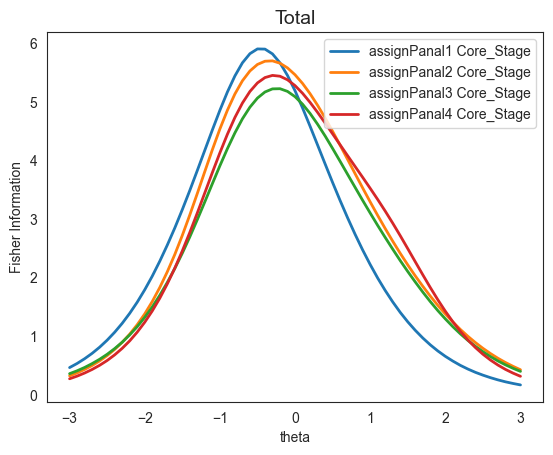

In [48]:
# 总的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == 'total') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Core_Stage')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Core_Stage')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Total', fontsize=14)
plt.savefig('./Core_Stage_Total.png', bbox_inches='tight')

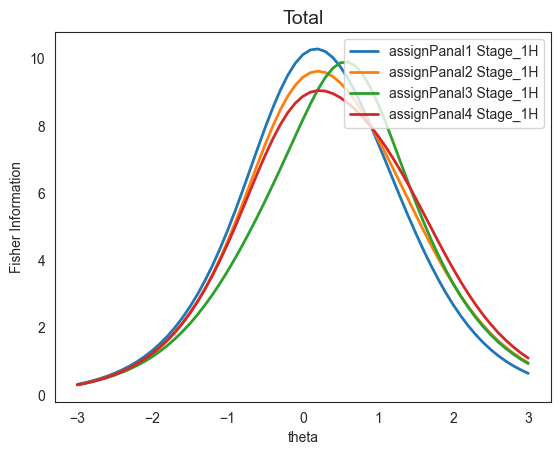

In [49]:
# 总的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == 'total') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_1H')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_1H')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Total', fontsize=14)
plt.savefig('./Stage_1H_Total.png', bbox_inches='tight')

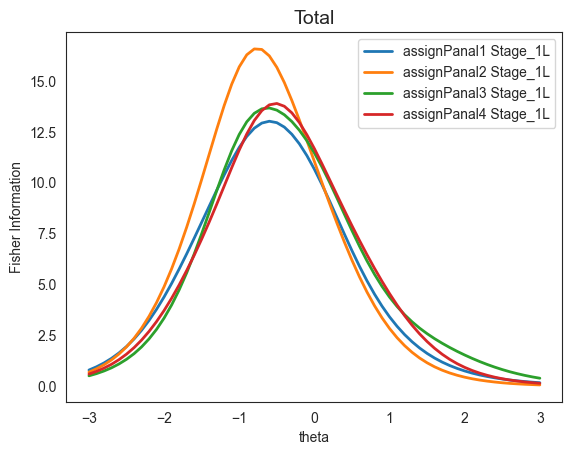

In [50]:
# 总的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == 'total') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_1L')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_1L')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Total', fontsize=14)
plt.savefig('./Stage_1L_Total.png', bbox_inches='tight')

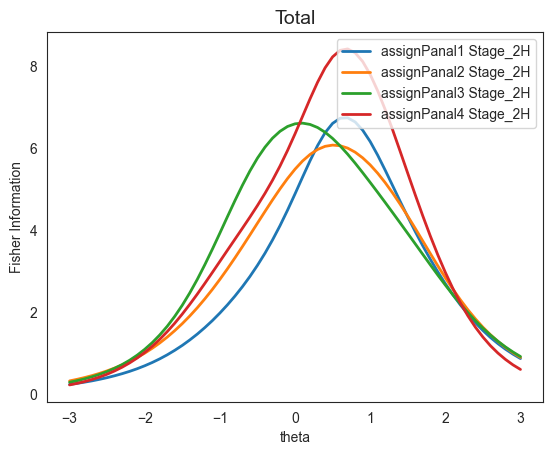

In [51]:
# 总的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == 'total') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_2H')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_2H')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Total', fontsize=14)
plt.savefig('./Stage_2H_Total.png', bbox_inches='tight')

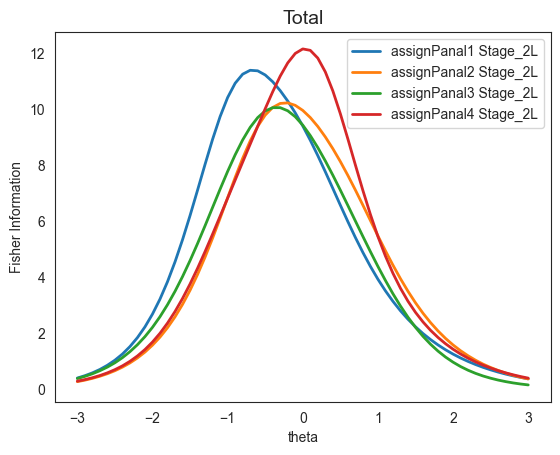

In [52]:
# 总的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == 'total') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_2L')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_2L')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Total', fontsize=14)
plt.savefig('./Stage_2L_Total.png', bbox_inches='tight')

#### 自动评分的信息量 

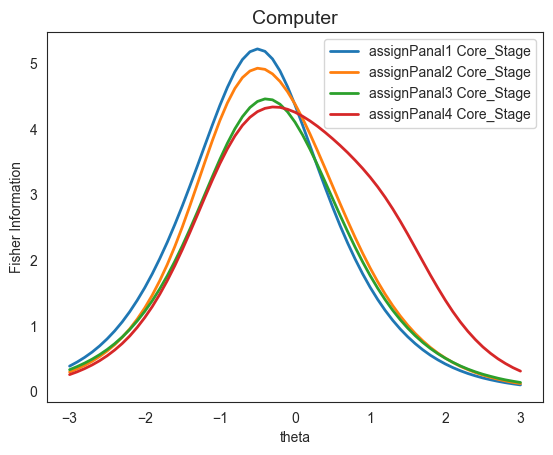

In [53]:
# 自动评分的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == '1') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Core_Stage')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Core_Stage')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Computer', fontsize=14)
plt.savefig('./Core_Stage_Computer.png', bbox_inches='tight')

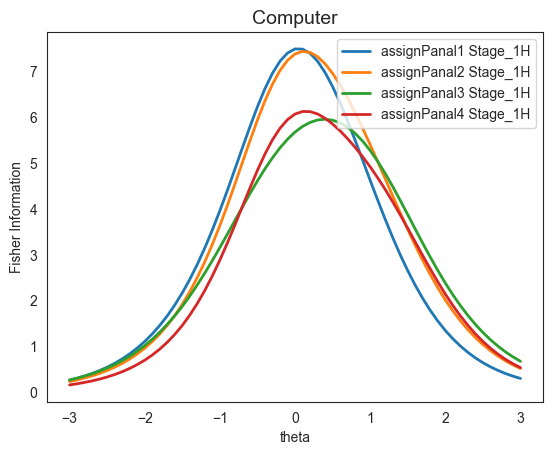

In [54]:
# 自动评分的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == '1') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_1H')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_1H')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Computer', fontsize=14)
plt.savefig('./Stage_1H_Computer.png', bbox_inches='tight')

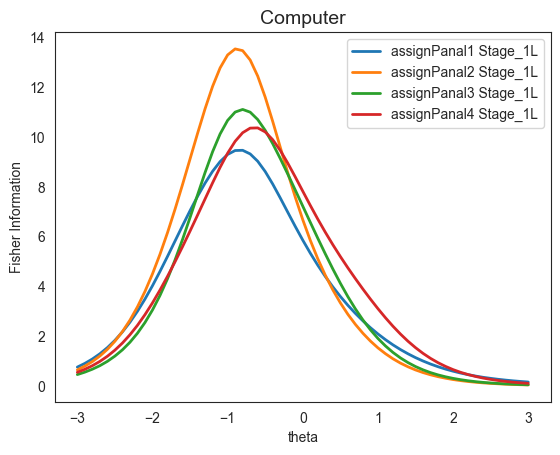

In [55]:
# 自动评分的信息量
for panal in ['assignPanal1','assignPanal2','assignPanal3','assignPanal4']:
    data = pd.DataFrame({'theta': thetas,
                        'Fisher Information': df_module_agg[(df_module_agg['Item_Format'] == '1') & (df_module_agg['Panal'] == panal) & (df_module_agg['Module'] == 'Stage_1L')].iloc[:, 3:].values[0]})
    sns.lineplot(x='theta', y='Fisher Information', data=data, linewidth=2, label=panal+' Stage_1L')
    # plt.xlabel('Theta', fontsize=12)
    # plt.ylabel('Fisher Information', fontsize=12)
    # plt.title(f'Core Stage Computer Scored', fontsize=14)
    plt.legend(fontsize=10,loc='upper right')
plt.title(f'Computer', fontsize=14)
plt.savefig('./Stage_1L_Computer.png', bbox_inches='tight')